In [1]:

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*torch.load.*weights_only=False.*")

import time

import utlis
from utlis import compute_pairwise_distance_metrics, compute_pairwise_inner_product_rank_correlation

import torch

import matplotlib.pyplot as plt

import torch._dynamo
torch._dynamo.config.suppress_errors = True

# First, check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:1


In [2]:
def test_SJLT_sparsity(projection_dims, sparsity_levels, mode="SJLT", activation_fn="relu", c=20, blow_up=1):
    # Store results for each sparsity level
    relative_errors_dist = {sparsity: [] for sparsity in sparsity_levels}
    spearman_correlations = {sparsity: [] for sparsity in sparsity_levels}
    times = {sparsity: [] for sparsity in sparsity_levels}
    overhead_times = {proj_dim: 0 for proj_dim in projection_dims}  # Overhead per projection dimension
    computation_times = {sparsity: [] for sparsity in sparsity_levels}
    memory_usage = {sparsity: [] for sparsity in sparsity_levels}  # For memory usage

    # Load and prepare the data
    # for i in range(10):
    for i in range(1):
        grad_t = torch.load(f"result/grad/{activation_fn}/grad_t_0_{i}.pt", map_location=device)
        if i == 0:
            batch_vec = grad_t
        else:
            batch_vec = torch.cat([batch_vec, grad_t], dim=0)

    batch_size, original_dim = batch_vec.size()

    # backup
    batch_vec_clone = batch_vec.clone()

    for proj_dim in projection_dims:
        torch.cuda.reset_peak_memory_stats(device)

        # warm up
        if mode in ["SJLT", "SJLT_batch"]:
            rand_indices = torch.randint(proj_dim * blow_up, (original_dim, c), device=device)
            rand_signs = torch.randint(0, 2, (original_dim, c), device=device) * 2 - 1
        elif mode == "SJLT_reverse":
            rand_indices = torch.randint(proj_dim, (original_dim, c), device=device)
            rand_signs = torch.randint(0, 2, (original_dim, c), device=device) * 2 - 1
            pos_indices, neg_indices = utlis.backward_SJLT_indices(original_dim, proj_dim, c, device, rand_indices, rand_signs)
        else:
            proj_matrix = torch.randn(proj_dim, original_dim, device=batch_vec.device) / (proj_dim ** 0.5)

        # Start timing for overhead
        torch.cuda.synchronize(device)
        overhead_start_time = time.time()

        if mode in ["SJLT", "SJLT_batch"]:
            rand_indices = torch.randint(proj_dim * blow_up, (original_dim, c), device=device)
            rand_signs = torch.randint(0, 2, (original_dim, c), device=device) * 2 - 1
        elif mode == "SJLT_reverse":
            rand_indices = torch.randint(proj_dim, (original_dim, c), device=device)
            rand_signs = torch.randint(0, 2, (original_dim, c), device=device) * 2 - 1
            pos_indices, neg_indices = utlis.backward_SJLT_indices(original_dim, proj_dim, c, device, rand_indices, rand_signs)
        else:
            proj_matrix = torch.randn(proj_dim, original_dim, device=batch_vec.device) / (proj_dim ** 0.5)

        # End timing for overhead
        torch.cuda.synchronize(device)
        overhead_end_time = time.time()
        overhead_times[proj_dim] = overhead_end_time - overhead_start_time

        for sparsity in sparsity_levels:
            batch_vec = batch_vec_clone.clone()

            # Sparsify the vectors by randomly setting a fraction (sparsity) of elements to zero
            num_elements_to_drop = int(sparsity * original_dim)
            if num_elements_to_drop > 0:
                for i in range(batch_size):
                    indices_to_drop = torch.randperm(original_dim)[:num_elements_to_drop]
                    batch_vec[i, indices_to_drop] = 0

            # Start timing for the actual projection
            torch.cuda.synchronize(device)
            computation_start_time = time.time()

            if mode == "SJLT":
                batch_vec_p = utlis.SJLT(batch_vec, proj_dim, rand_indices=rand_indices, rand_signs=rand_signs, c=20, blow_up=blow_up)
            elif mode == "SJLT_batch":
                batch_vec_p = utlis.SJLT_batch(batch_vec, proj_dim, rand_indices=rand_indices, rand_signs=rand_signs, c=20, blow_up=blow_up)
            elif mode == "SJLT_reverse":
                batch_vec_p = utlis.SJLT_reverse(batch_vec, proj_dim, pos_indices=pos_indices, neg_indices=neg_indices, c=20)
            else:
                batch_vec_p = batch_vec @ proj_matrix.T

            # End timing for the actual projection
            torch.cuda.synchronize(device)
            computation_end_time = time.time()

            # Calculate relative error for the current sparsity
            relative_error = compute_pairwise_distance_metrics(batch_vec, batch_vec_p)
            relative_errors_dist[sparsity].append(relative_error)

            # Calculate Spearman rank correlation for inner products
            spearman_corr = compute_pairwise_inner_product_rank_correlation(batch_vec, batch_vec_p)
            spearman_correlations[sparsity].append(spearman_corr)

            # Record times
            computation_time = computation_end_time - computation_start_time
            total_time = overhead_times[proj_dim] + computation_time

            computation_times[sparsity].append(computation_time)
            times[sparsity].append(total_time)

            peak_mem = torch.cuda.max_memory_allocated(device)
            memory_usage[sparsity].append(peak_mem / 1024**3)  # Store peak memory in GB


    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()

    # Define the metrics, titles, and y-axis labels for plotting
    metrics = [
        (relative_errors_dist, "Relative Errors", "Relative Error (Mean)"),
        (spearman_correlations, "Spearman Correlation", "Correlation"),
        (times, "Total Time", "Time (s)"),
        (memory_usage, "Memory Usage", "Memory (GB)"),
        (computation_times, "Computation Time", "Time (s)"),
    ]

    # Loop through each metric for streamlined plotting
    for i, (metric, title, ylabel) in enumerate(metrics):
        ax = axes[i]
        for sparsity in sparsity_levels:
            ax.plot(projection_dims, metric[sparsity], marker='o', label=f"Sparsity: {sparsity}")
        ax.set_xticks(projection_dims)
        ax.set_title(f"{title} vs. Projection Dimension")
        ax.set_xlabel("Projection Dimension")
        ax.set_ylabel(ylabel)
        ax.legend()

    # Plot overhead times in the last subplot
    ax = axes[-1]
    ax.plot(projection_dims, [overhead_times[proj_dim] for proj_dim in projection_dims], marker='o', label="Overhead Time")
    ax.set_xticks(projection_dims)
    ax.set_title("Overhead Time vs. Projection Dimension")
    ax.set_xlabel("Projection Dimension")
    ax.set_ylabel("Overhead Time (seconds)")
    ax.legend()

    plt.tight_layout()
    plt.show()

def test_SJLT_activations(projection_dims, activation_fns, mode="SJLT", c=20, blow_up=1):
    """
    Test SJLT with different activation functions and measure performance.

    Args:
        projection_dims (list): List of projection dimensions to test.
        activation_fns (list): List of activation function names.
        mode (str): SJLT mode, default is "SJLT".
        c (int): Sparsity parameter for SJLT.
        blow_up (int): Dimension multiplier for SJLT.

    Returns:
        None
    """
    # Initialize storage for results
    relative_errors_dist = {activation_fn: [] for activation_fn in activation_fns}
    spearman_correlations = {activation_fn: [] for activation_fn in activation_fns}
    times = {activation_fn: [] for activation_fn in activation_fns}
    overhead_times = {proj_dim: 0 for proj_dim in projection_dims}
    computation_times = {activation_fn: [] for activation_fn in activation_fns}
    memory_usage = {activation_fn: [] for activation_fn in activation_fns}

    # Load and prepare the data for each activation function
    for activation_fn in activation_fns:

        for i in range(1):  # Modify to load more samples if needed
            grad_t = torch.load(f"result/grad/{activation_fn}/grad_t_0_{i}.pt", map_location=device)
            if i == 0:
                batch_vec = grad_t
            else:
                batch_vec = torch.cat([batch_vec, grad_t], dim=0)

        batch_size, original_dim = batch_vec.size()
        batch_vec_clone = batch_vec.clone()  # Backup for repeated tests

        for proj_dim in projection_dims:
            torch.cuda.reset_peak_memory_stats(device)

            # Generate random projections or other data based on mode
            if mode in ["SJLT", "SJLT_batch"]:
                rand_indices = torch.randint(proj_dim * blow_up, (original_dim, c), device=device)
                rand_signs = torch.randint(0, 2, (original_dim, c), device=device) * 2 - 1
            elif mode == "SJLT_reverse":
                rand_indices = torch.randint(proj_dim, (original_dim, c), device=device)
                rand_signs = torch.randint(0, 2, (original_dim, c), device=device) * 2 - 1
                pos_indices, neg_indices = utlis.backward_SJLT_indices(original_dim, proj_dim, c, device, rand_indices, rand_signs)
            else:
                proj_matrix = torch.randn(proj_dim, original_dim, device=batch_vec.device) / (proj_dim ** 0.5)

            # Measure overhead time
            torch.cuda.synchronize(device)
            overhead_start_time = time.time()

            if mode in ["SJLT", "SJLT_batch"]:
                rand_indices = torch.randint(proj_dim * blow_up, (original_dim, c), device=device)
                rand_signs = torch.randint(0, 2, (original_dim, c), device=device) * 2 - 1
            elif mode == "SJLT_reverse":
                rand_indices = torch.randint(proj_dim, (original_dim, c), device=device)
                rand_signs = torch.randint(0, 2, (original_dim, c), device=device) * 2 - 1
                pos_indices, neg_indices = utlis.backward_SJLT_indices(original_dim, proj_dim, c, device, rand_indices, rand_signs)
            else:
                proj_matrix = torch.randn(proj_dim, original_dim, device=batch_vec.device) / (proj_dim ** 0.5)

            torch.cuda.synchronize(device)
            overhead_end_time = time.time()
            overhead_times[proj_dim] = overhead_end_time - overhead_start_time

            batch_vec = batch_vec_clone.clone()  # Restore the original batch vector

            # Measure computation time for the projection
            torch.cuda.synchronize(device)
            computation_start_time = time.time()

            if mode == "SJLT":
                batch_vec_p = utlis.SJLT(batch_vec, proj_dim, rand_indices=rand_indices, rand_signs=rand_signs, c=c, blow_up=blow_up)
            elif mode == "SJLT_batch":
                batch_vec_p = utlis.SJLT_batch(batch_vec, proj_dim, rand_indices=rand_indices, rand_signs=rand_signs, c=c, blow_up=blow_up)
            elif mode == "SJLT_reverse":
                batch_vec_p = utlis.SJLT_reverse(batch_vec, proj_dim, pos_indices=pos_indices, neg_indices=neg_indices, c=c)
            else:
                batch_vec_p = batch_vec @ proj_matrix.T

            torch.cuda.synchronize(device)
            computation_end_time = time.time()

            # Compute metrics
            relative_error = compute_pairwise_distance_metrics(batch_vec, batch_vec_p)
            spearman_corr = compute_pairwise_inner_product_rank_correlation(batch_vec, batch_vec_p)

            relative_errors_dist[activation_fn].append(relative_error)
            spearman_correlations[activation_fn].append(spearman_corr)

            computation_time = computation_end_time - computation_start_time
            total_time = overhead_times[proj_dim] + computation_time

            computation_times[activation_fn].append(computation_time)
            times[activation_fn].append(total_time)

            peak_mem = torch.cuda.max_memory_allocated(device)
            memory_usage[activation_fn].append(peak_mem / 1024**3)  # Convert to GB

    # Plotting updated for activation functions
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()

    for i, (metric, label, ylabel) in enumerate([
        (relative_errors_dist, "Relative Errors", "Relative Error (Mean)"),
        (spearman_correlations, "Spearman Correlation", "Correlation"),
        (times, "Total Time", "Time (s)"),
        (memory_usage, "Memory Usage", "Memory (GB)"),
        (computation_times, "Computation Time", "Time (s)"),
    ]):
        ax = axes[i]
        for activation_fn in activation_fns:
            ax.plot(projection_dims, metric[activation_fn], marker='o', label=f"Activation: {activation_fn}")
        ax.set_xticks(projection_dims)
        ax.set_title(f"{label} vs. Projection Dimension")
        ax.set_xlabel("Projection Dimension")
        ax.set_ylabel(ylabel)
        ax.legend()

    # Overhead Time Plot
    ax = axes[-1]
    ax.plot(projection_dims, [overhead_times[proj_dim] for proj_dim in projection_dims], marker='o', label="Overhead Time")
    ax.set_xticks(projection_dims)
    ax.set_title("Overhead Time vs. Projection Dimension")
    ax.set_xlabel("Projection Dimension")
    ax.set_ylabel("Overhead Time (seconds)")
    ax.legend()

    plt.tight_layout()
    plt.show()

def test_SJLT_blow_up(projection_dims, blow_ups, mode="SJLT", activation_fn="relu", c=20):
    # Store results for each blow_up level
    relative_errors_dist = {blow_up: [] for blow_up in blow_ups}
    spearman_correlations = {blow_up: [] for blow_up in blow_ups}
    times = {blow_up: [] for blow_up in blow_ups}
    overhead_times = {blow_up: [] for blow_up in blow_ups}  # Overhead per projection dimension
    computation_times = {blow_up: [] for blow_up in blow_ups}
    memory_usage = {blow_up: [] for blow_up in blow_ups}  # For memory usage

    # Load and prepare the data
    for i in range(2):  # Using only one batch for this test
        grad_t = torch.load(f"result/grad/{activation_fn}/grad_t_0_{i}.pt", map_location=device)
        if i == 0:
            batch_vec = grad_t
        else:
            batch_vec = torch.cat([batch_vec, grad_t], dim=0)

    batch_size, original_dim = batch_vec.size()

    # Backup of original data for reuse
    batch_vec_clone = batch_vec.clone()

    for proj_dim in projection_dims:
        for blow_up in blow_ups:
            torch.cuda.reset_peak_memory_stats(device)

            # Measure overhead time
            torch.cuda.synchronize(device)
            overhead_start_time = time.time()

            if mode in ["SJLT", "SJLT_batch"]:
                rand_indices = torch.randint(proj_dim * blow_up, (original_dim, c), device=device)
                rand_signs = torch.randint(0, 2, (original_dim, c), device=device) * 2 - 1
            elif mode == "SJLT_reverse":
                rand_indices = torch.randint(proj_dim, (original_dim, c), device=device)
                rand_signs = torch.randint(0, 2, (original_dim, c), device=device) * 2 - 1
                pos_indices, neg_indices = utlis.backward_SJLT_indices(original_dim, proj_dim, c, device, rand_indices, rand_signs)
            else:
                proj_matrix = torch.randn(proj_dim, original_dim, device=batch_vec.device) / (proj_dim ** 0.5)

            torch.cuda.synchronize(device)
            overhead_end_time = time.time()

            overhead_time = overhead_end_time - overhead_start_time

            batch_vec = batch_vec_clone.clone()

            # Start timing for the actual projection
            torch.cuda.synchronize(device)
            computation_start_time = time.time()

            if mode == "SJLT":
                batch_vec_p = utlis.SJLT(batch_vec, proj_dim, rand_indices=rand_indices, rand_signs=rand_signs, c=c, blow_up=blow_up)
            elif mode == "SJLT_batch":
                batch_vec_p = utlis.SJLT_batch(batch_vec, proj_dim, rand_indices=rand_indices, rand_signs=rand_signs, c=c, blow_up=blow_up)
            elif mode == "SJLT_reverse":
                batch_vec_p = utlis.SJLT_reverse(batch_vec, proj_dim, pos_indices=pos_indices, neg_indices=neg_indices, c=c)
            else:
                batch_vec_p = batch_vec @ proj_matrix.T

            # End timing for the actual projection
            torch.cuda.synchronize(device)
            computation_end_time = time.time()

            # Calculate relative error for the current blow_up level
            relative_error = compute_pairwise_distance_metrics(batch_vec, batch_vec_p)
            relative_errors_dist[blow_up].append(relative_error)

            # Calculate Spearman rank correlation for inner products
            spearman_corr = compute_pairwise_inner_product_rank_correlation(batch_vec, batch_vec_p)
            spearman_correlations[blow_up].append(spearman_corr)

            # Record times
            computation_time = computation_end_time - computation_start_time
            total_time = overhead_time + computation_time

            computation_times[blow_up].append(computation_time)
            overhead_times[blow_up].append(overhead_time)
            times[blow_up].append(total_time)

            peak_mem = torch.cuda.max_memory_allocated(device)
            memory_usage[blow_up].append(peak_mem / 1024**3)  # Store peak memory in GB

    # Plot results
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()

    # Define the metrics, titles, and y-axis labels for plotting
    metrics = [
        (relative_errors_dist, "Relative Errors", "Relative Error (Mean)"),
        (spearman_correlations, "Spearman Correlation", "Correlation"),
        (times, "Total Time", "Time (s)"),
        (memory_usage, "Memory Usage", "Memory (GB)"),
        (computation_times, "Computation Time", "Time (s)"),
        (overhead_times, "Overhead Time", "Time (s)"),
    ]

    # Loop through each metric for streamlined plotting
    for i, (metric, title, ylabel) in enumerate(metrics):
        ax = axes[i]
        for blow_up in blow_ups:
            ax.plot(projection_dims, metric[blow_up], marker='o', label=f"Blow Up: {blow_up}")
        ax.set_xticks(projection_dims)
        ax.set_title(f"{title} vs. Projection Dimension")
        ax.set_xlabel("Projection Dimension")
        ax.set_ylabel(ylabel)
        ax.legend()

    plt.tight_layout()
    plt.show()

Mode: SJLT


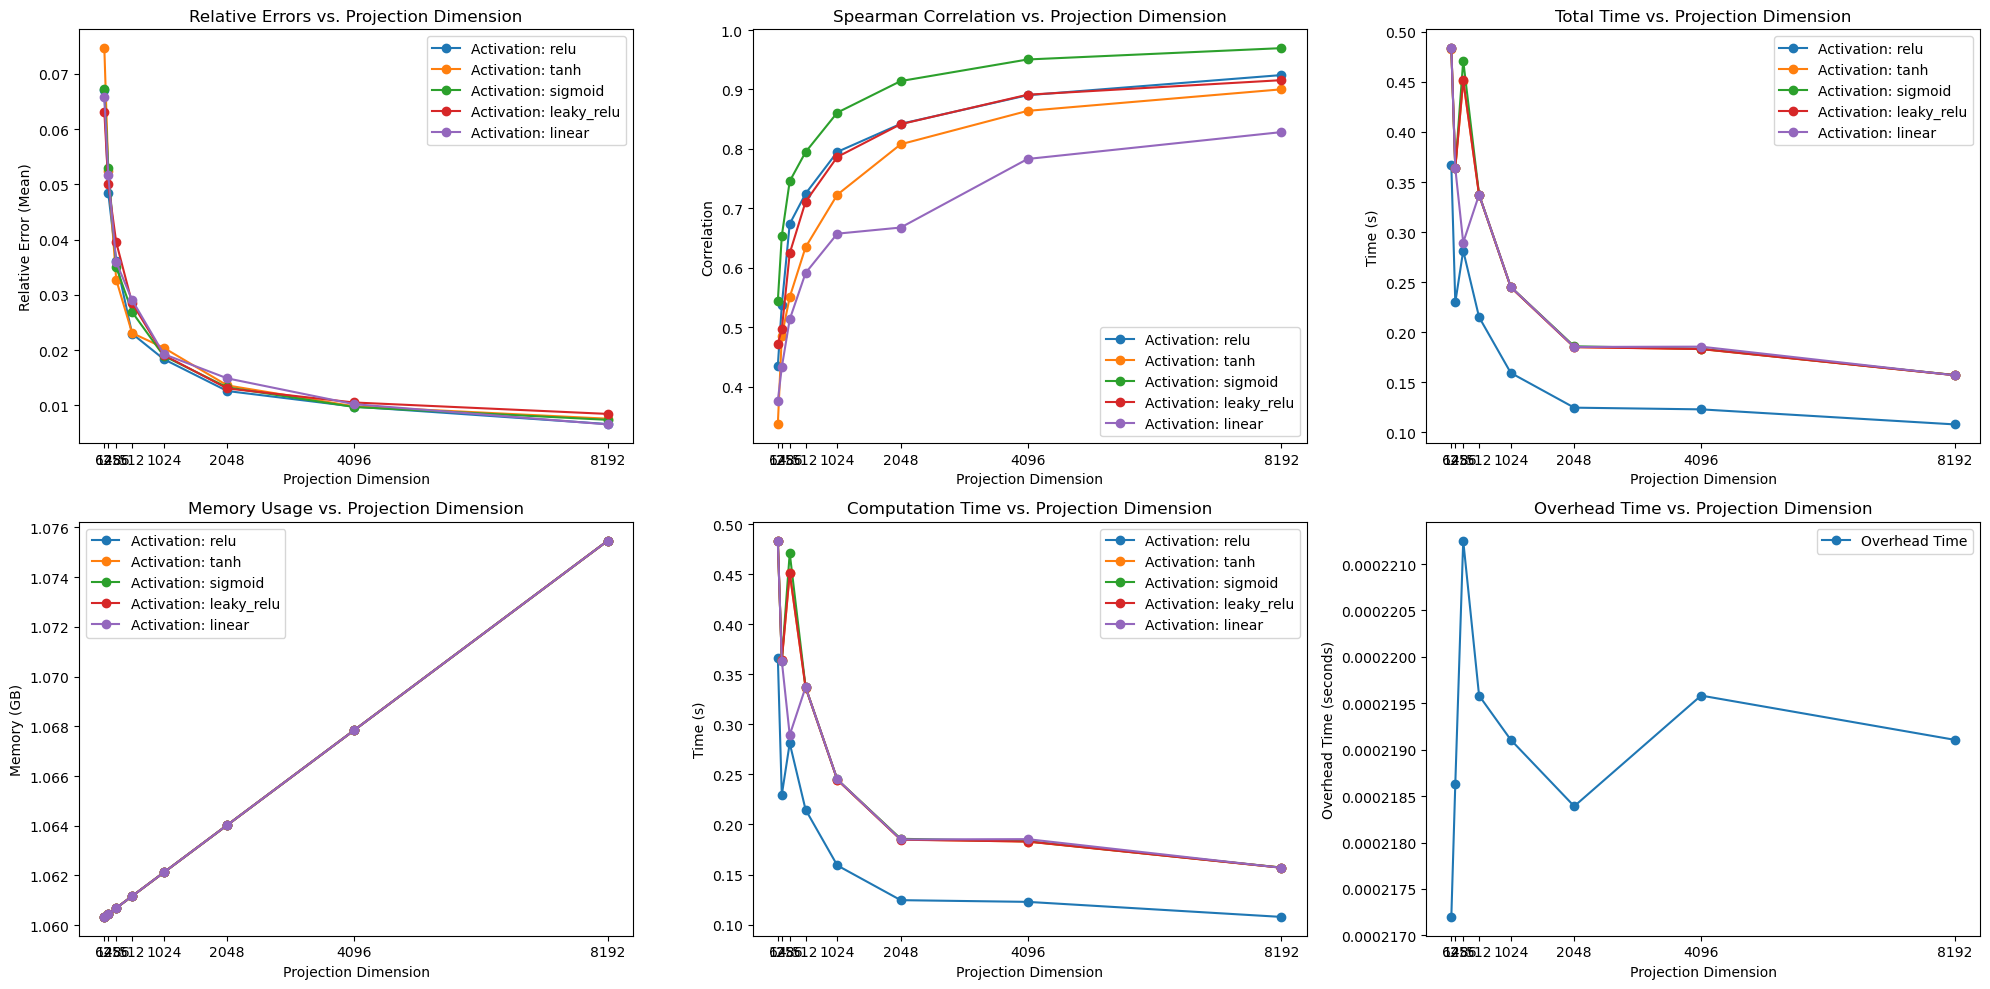

Mode: SJLT_batch


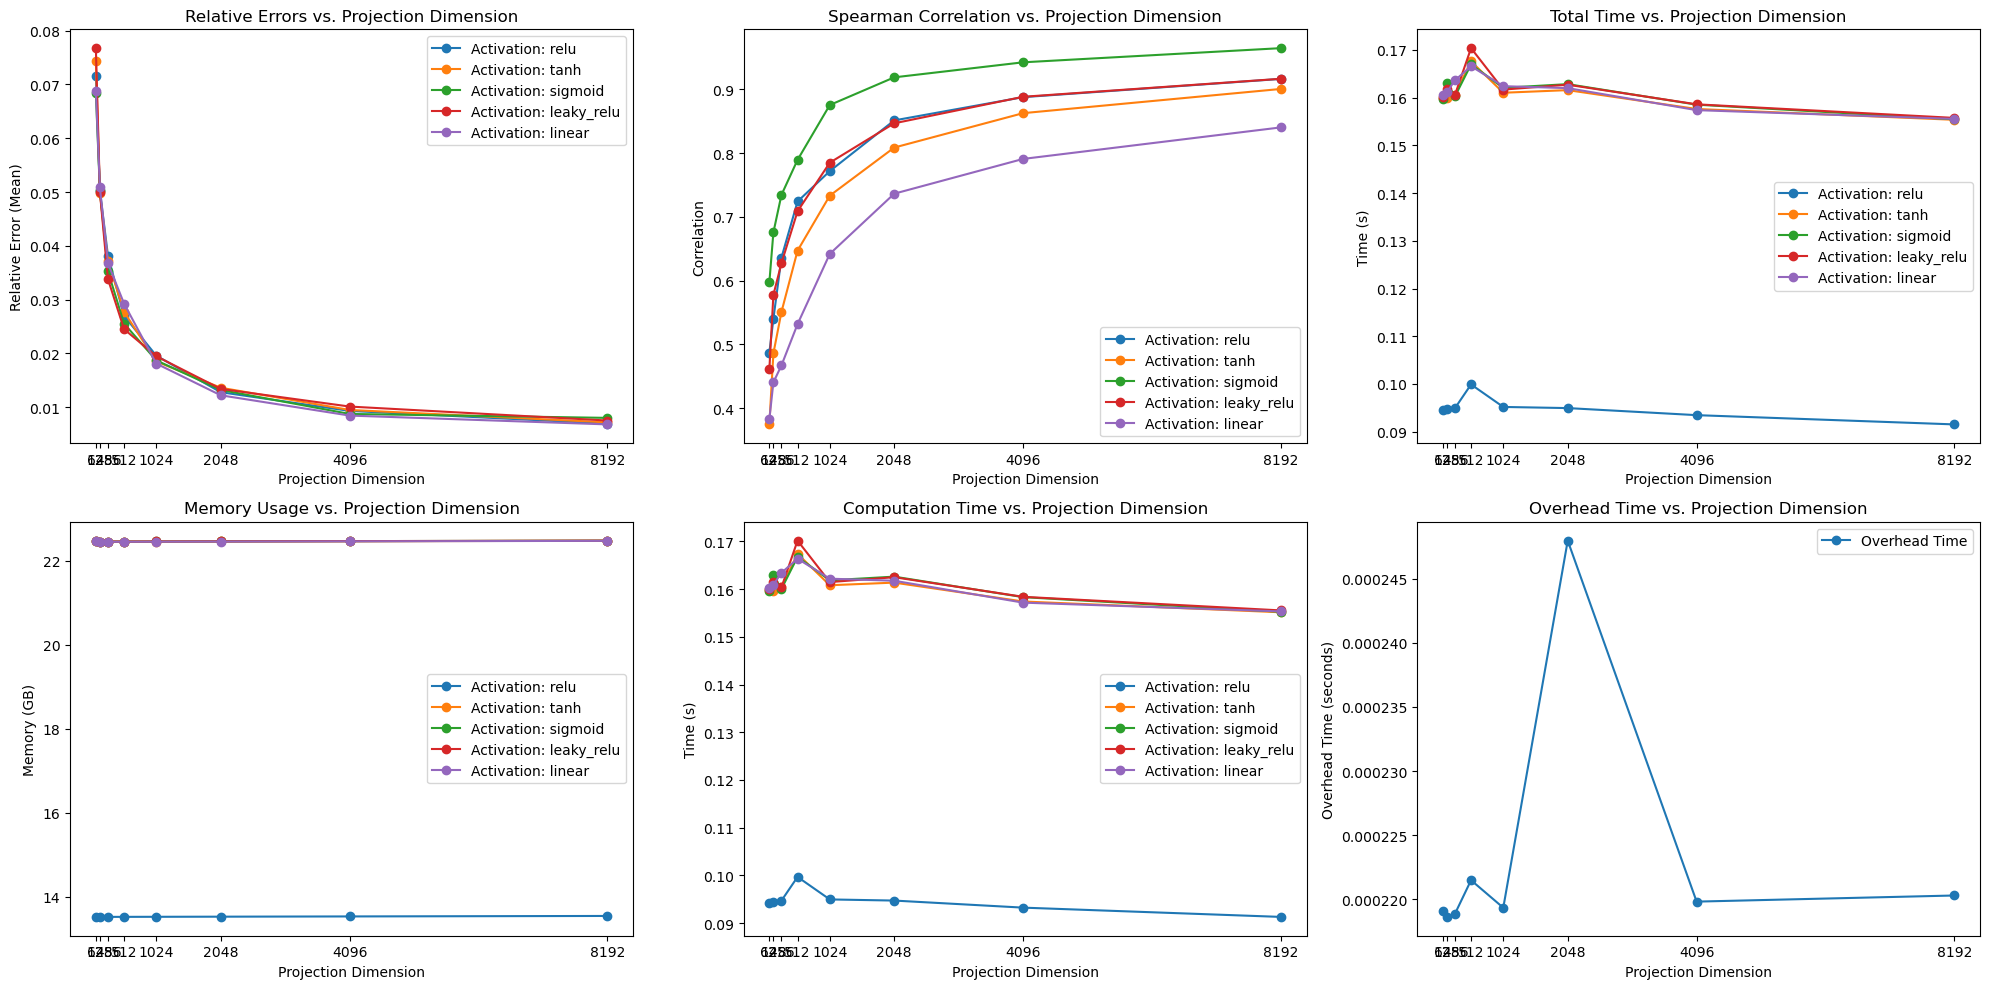

Mode: SJLT_reverse


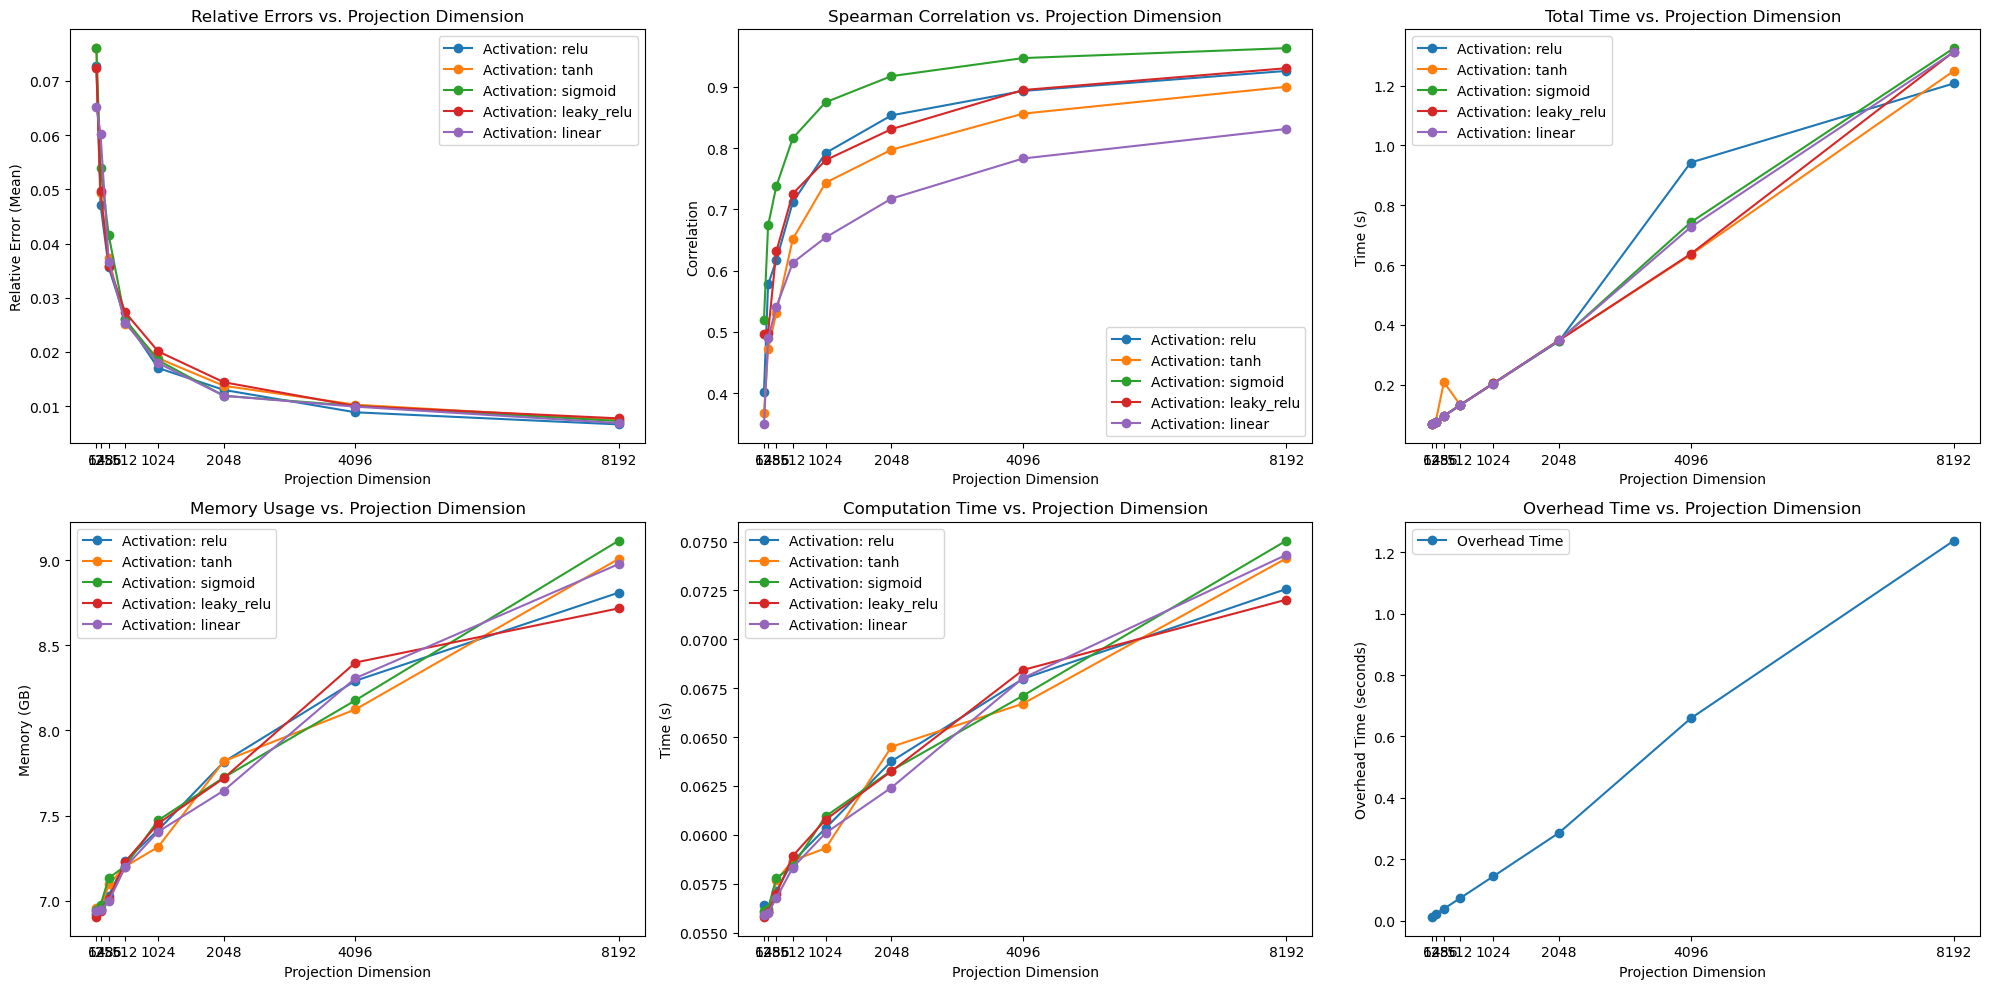

In [3]:
# projection_dims = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
projection_dims = [64, 128, 256, 512, 1024, 2048, 4096, 8192]
activation_fns = ["relu", "tanh", "sigmoid", "leaky_relu", "linear"]

for mode in ["SJLT", "SJLT_batch", "SJLT_reverse"]:
    print(f"Mode: {mode}")
    test_SJLT_activations(projection_dims, activation_fns=activation_fns, mode=mode, c=20, blow_up=1)

Mode: SJLT


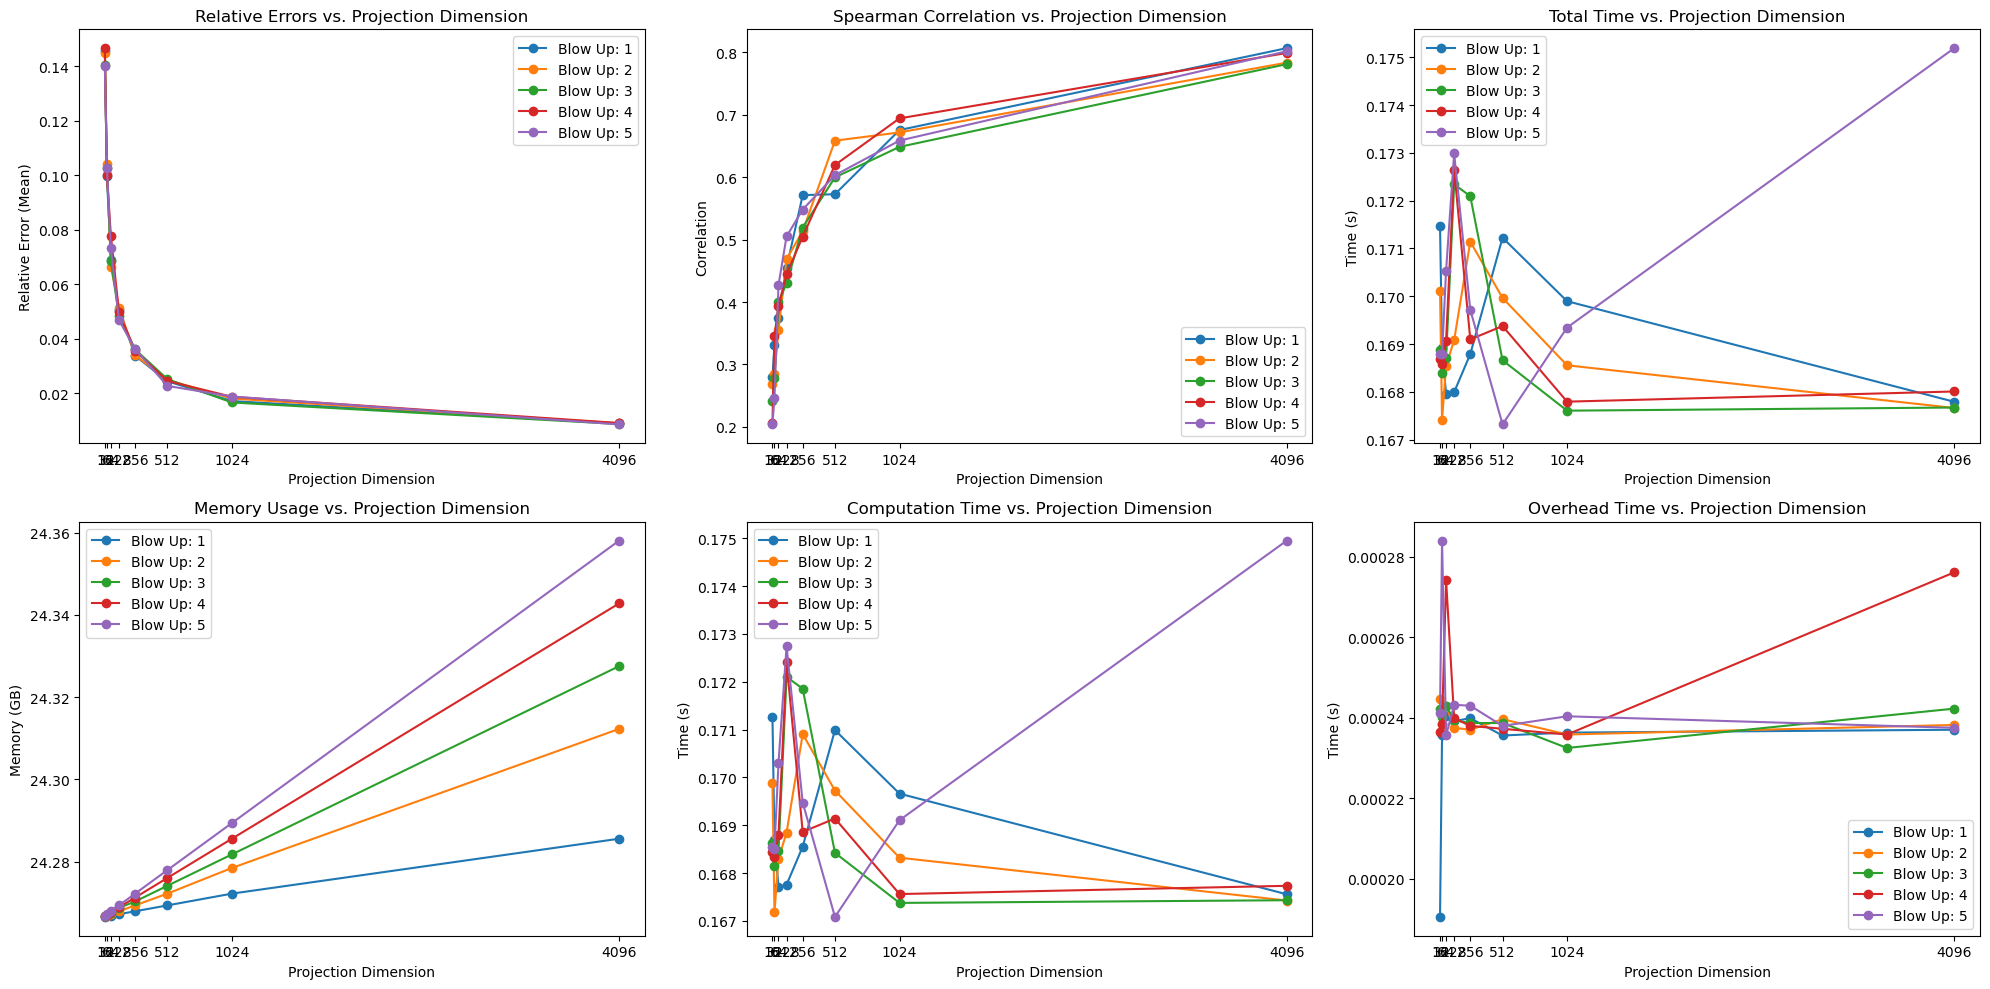

Mode: SJLT_batch


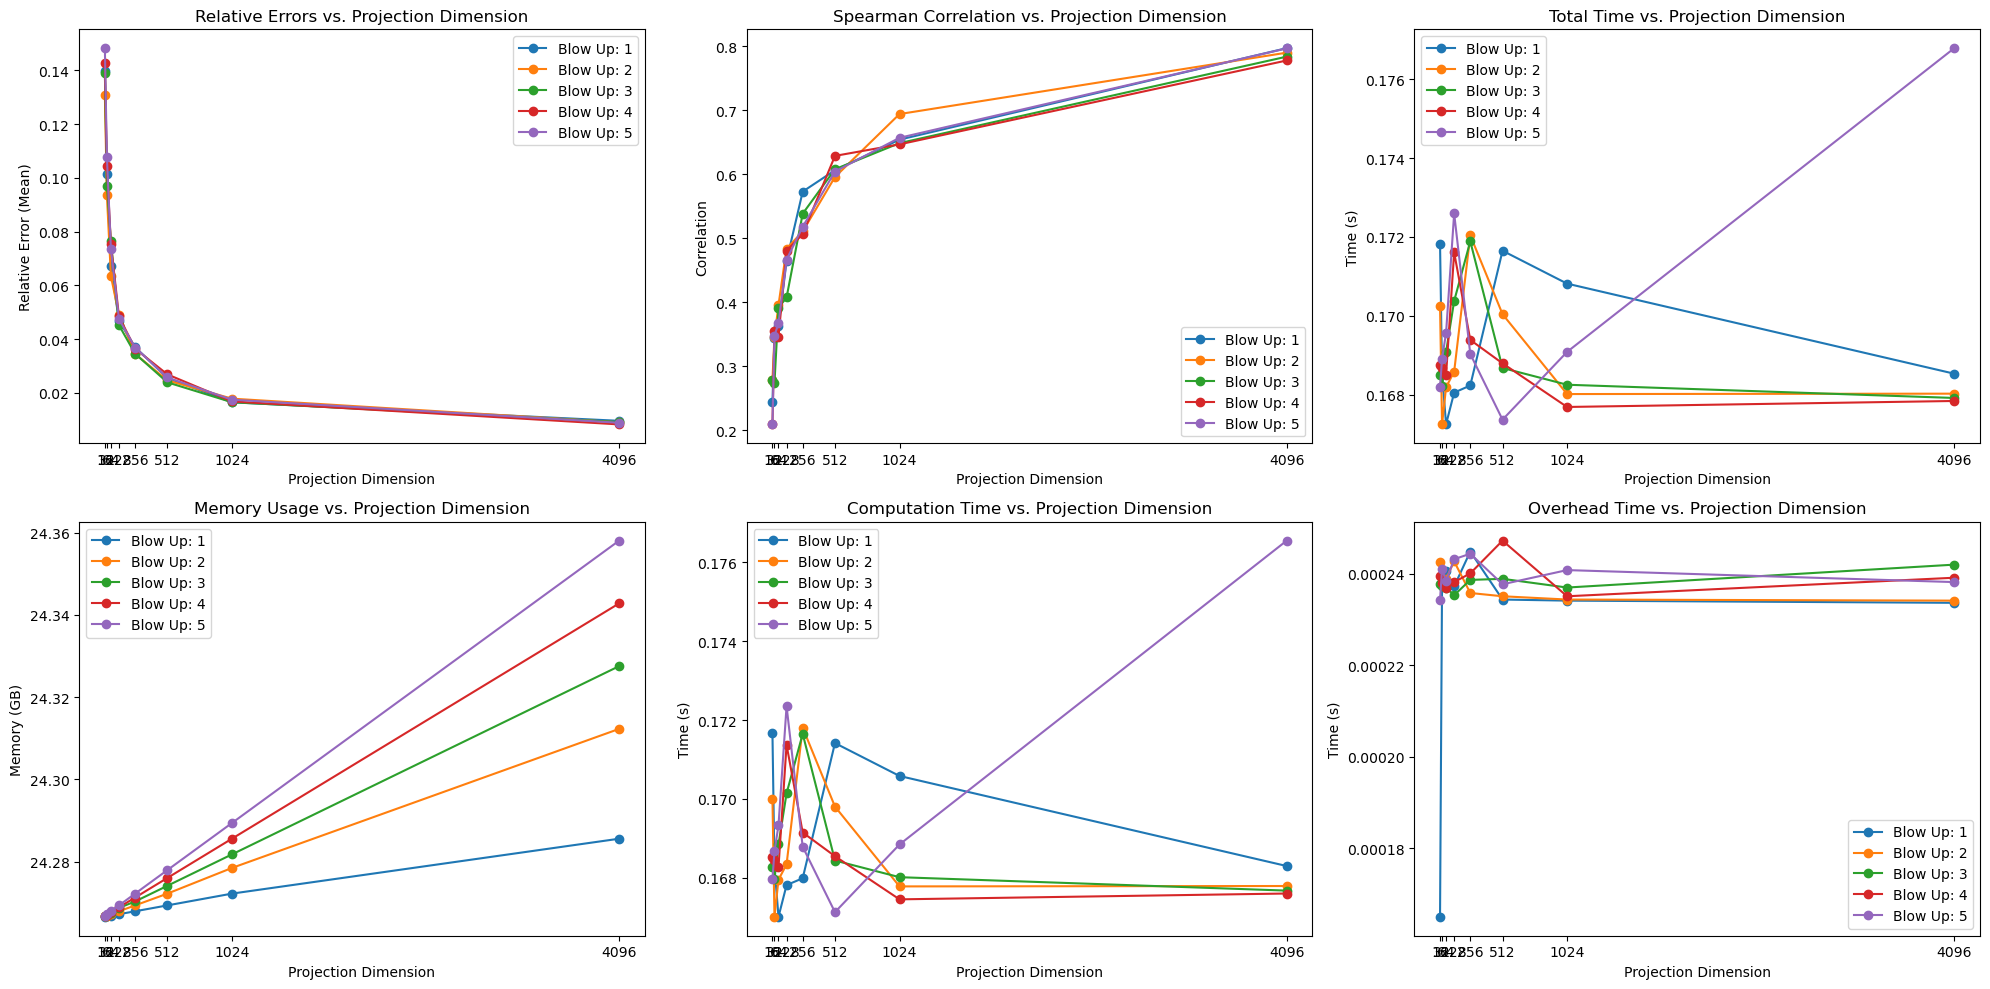

Mode: SJLT_reverse


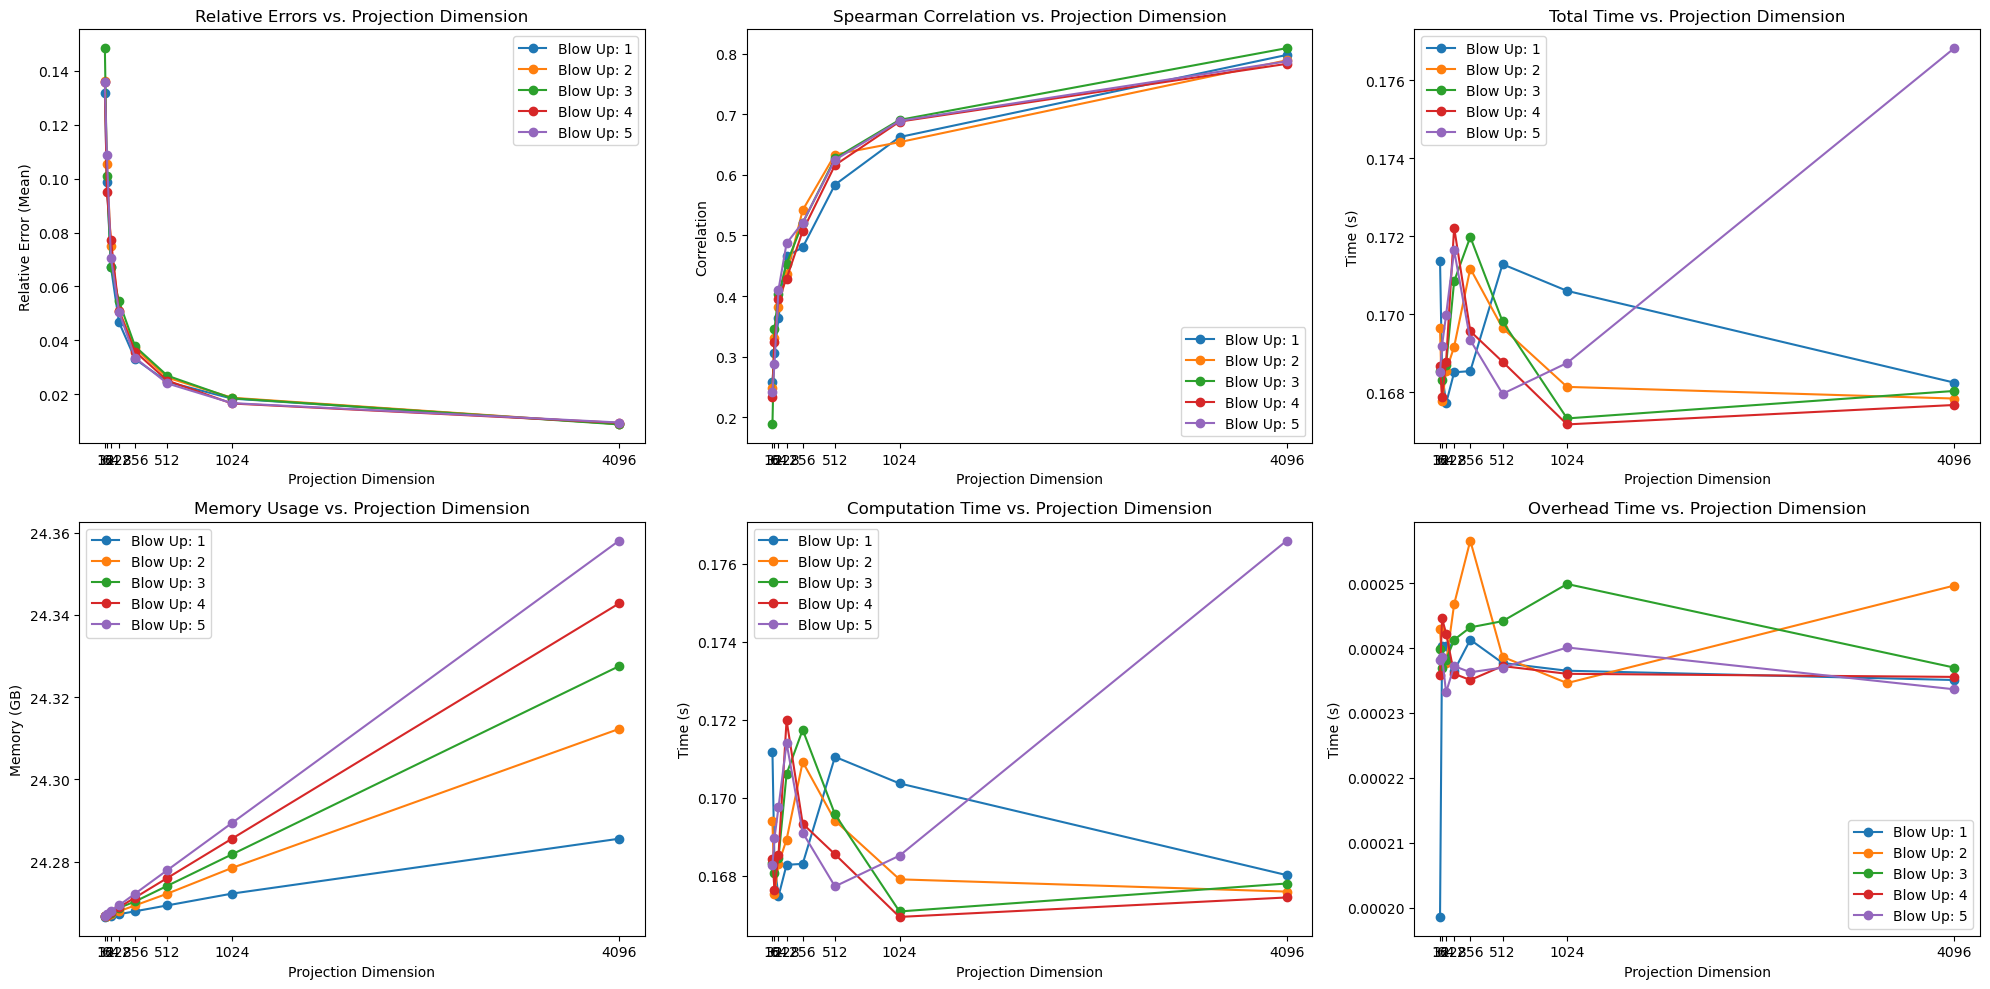

In [6]:
# projection_dims = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
projection_dims = [16, 32, 64, 128, 256, 512, 1024, 4096]
blow_ups = [1, 2, 3, 4, 5]

for mode in ["SJLT", "SJLT_batch", "SJLT_reverse"]:
    print(f"Mode: {mode}")
    test_SJLT_blow_up(projection_dims, blow_ups=blow_ups, mode="SJLT_batch", activation_fn="linear", c=10)

Activation function: relu
Mode: SJLT


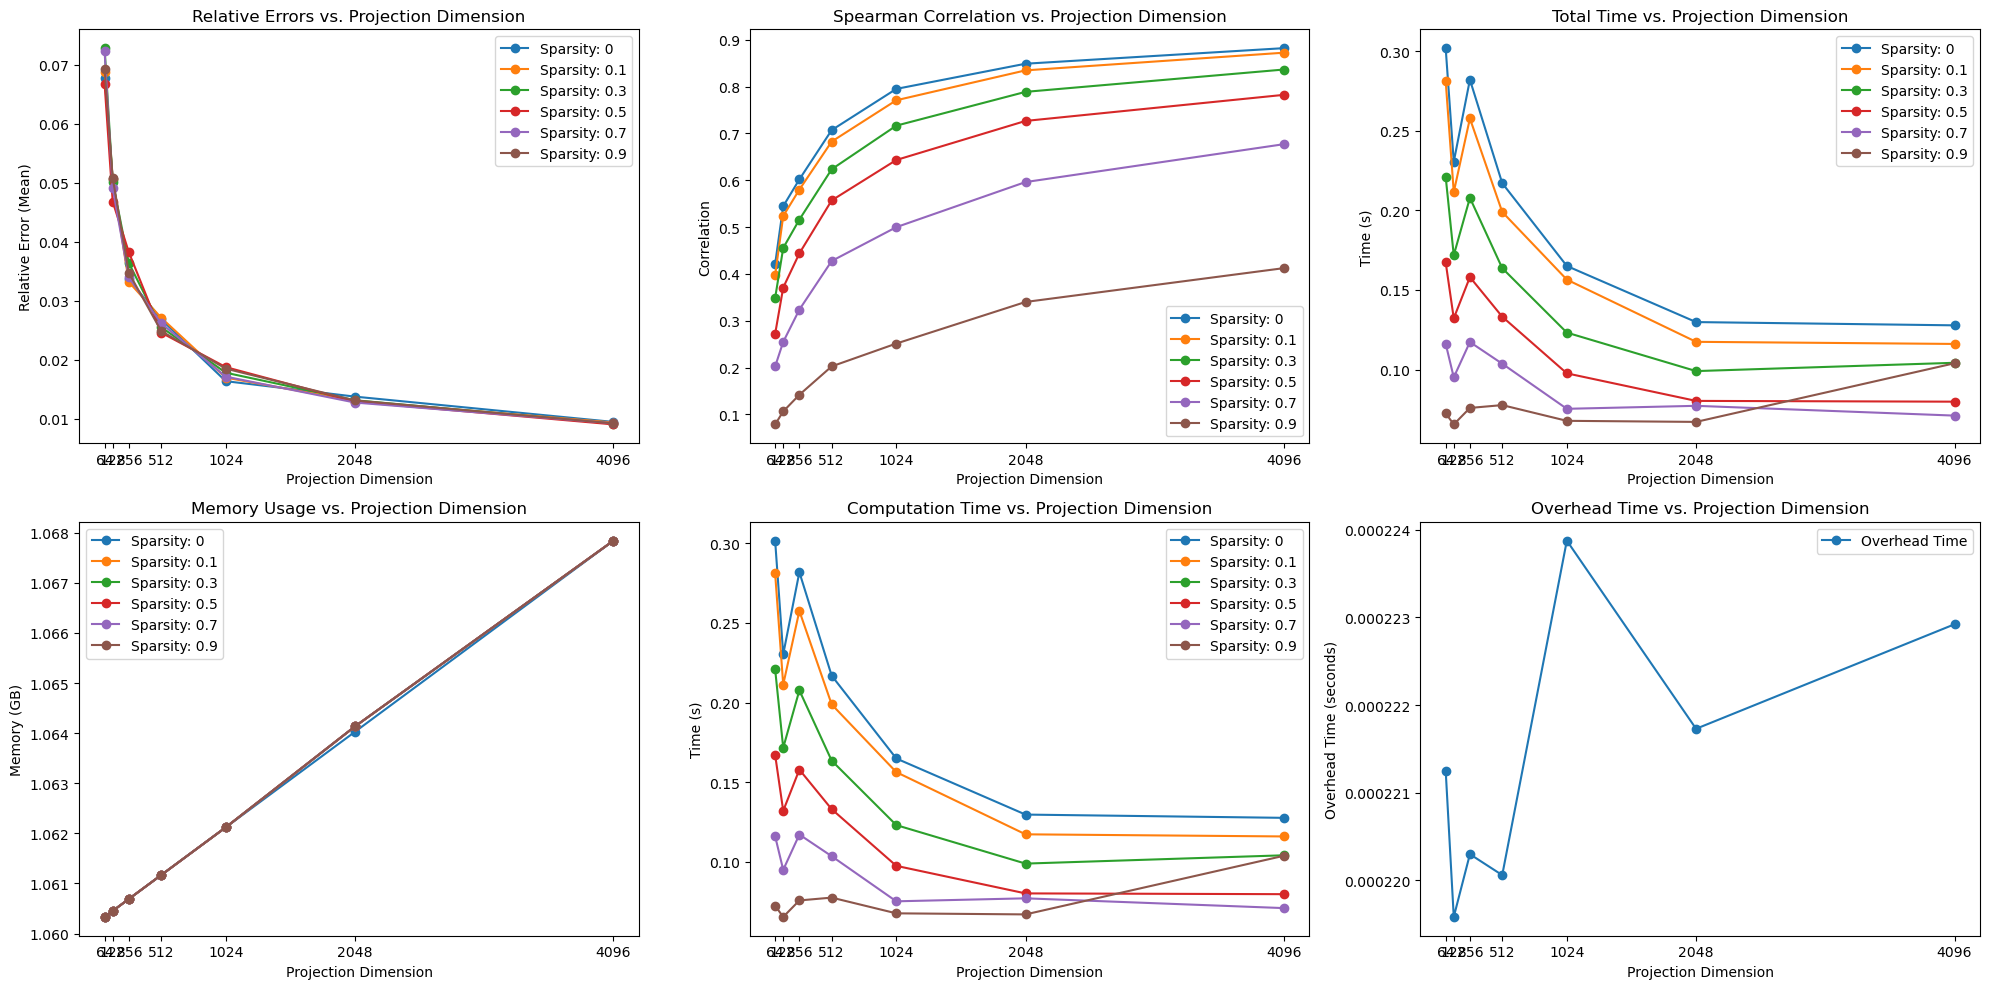

Mode: SJLT_batch


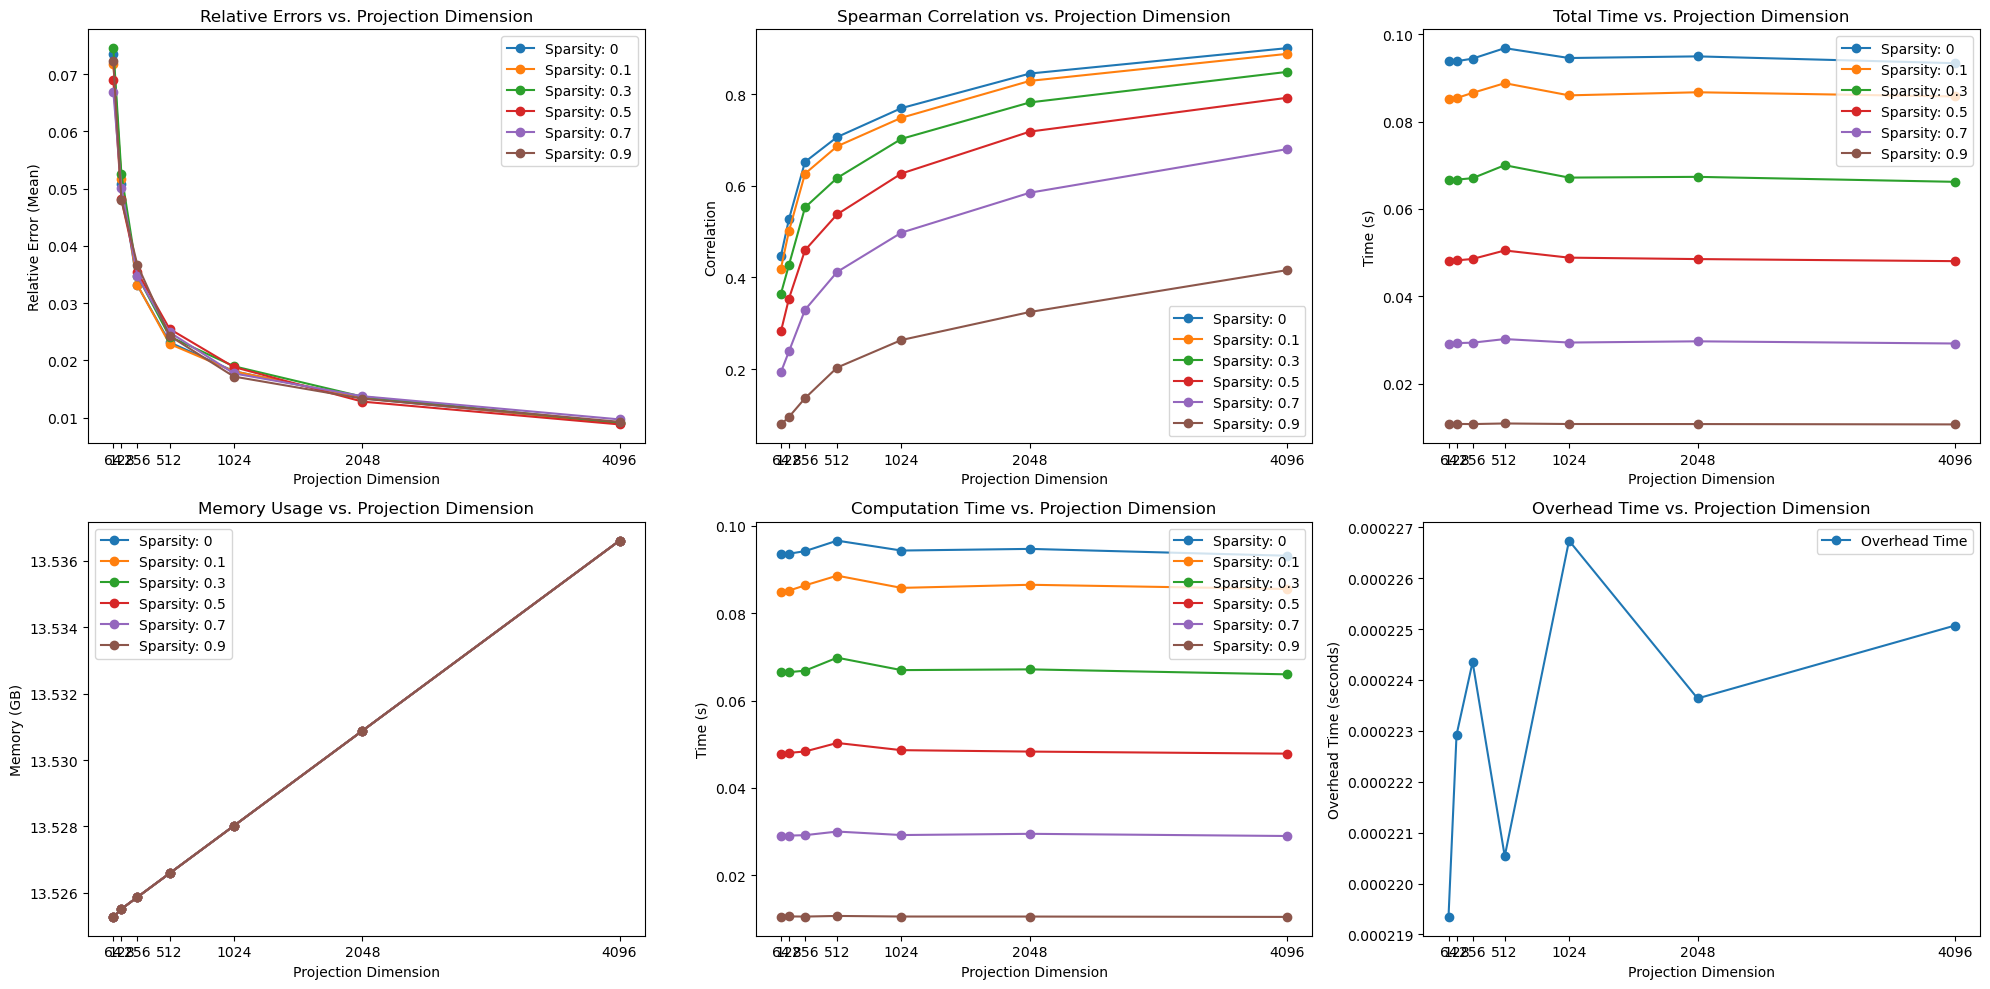

Mode: SJLT_reverse


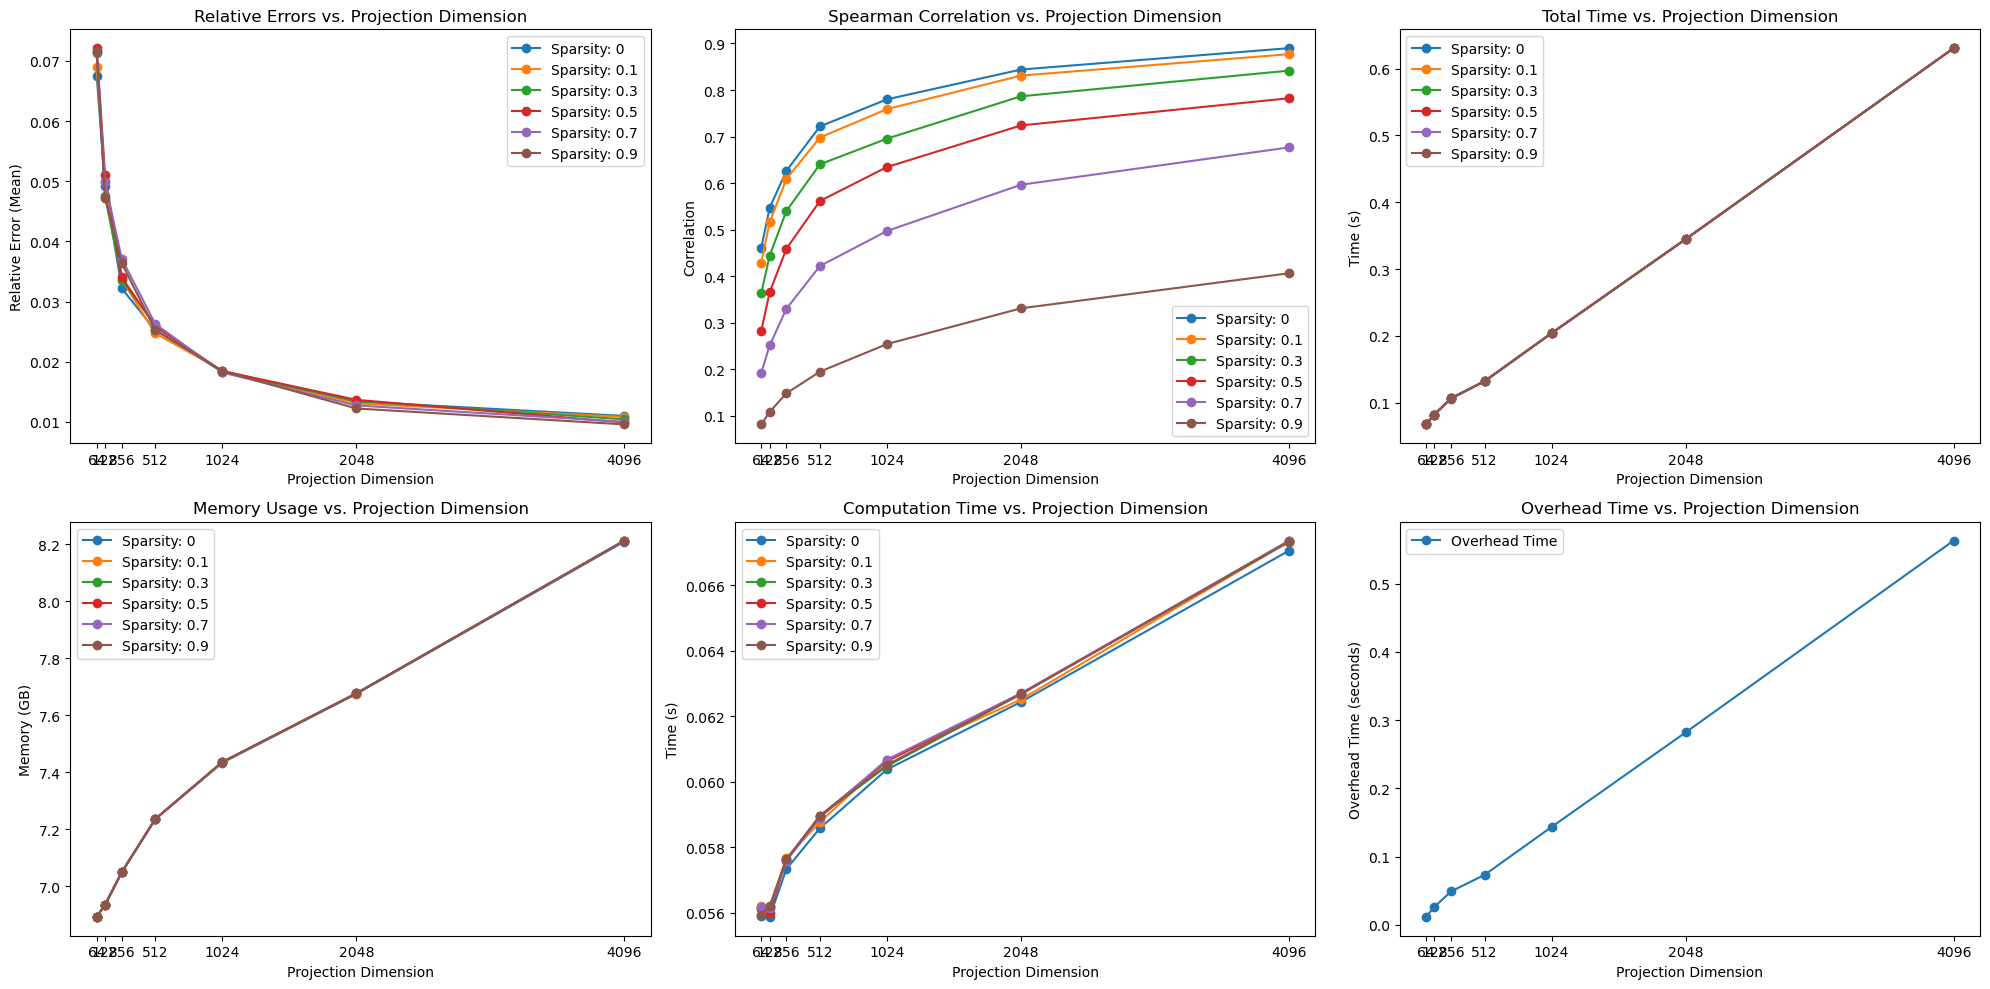

Activation function: tanh
Mode: SJLT


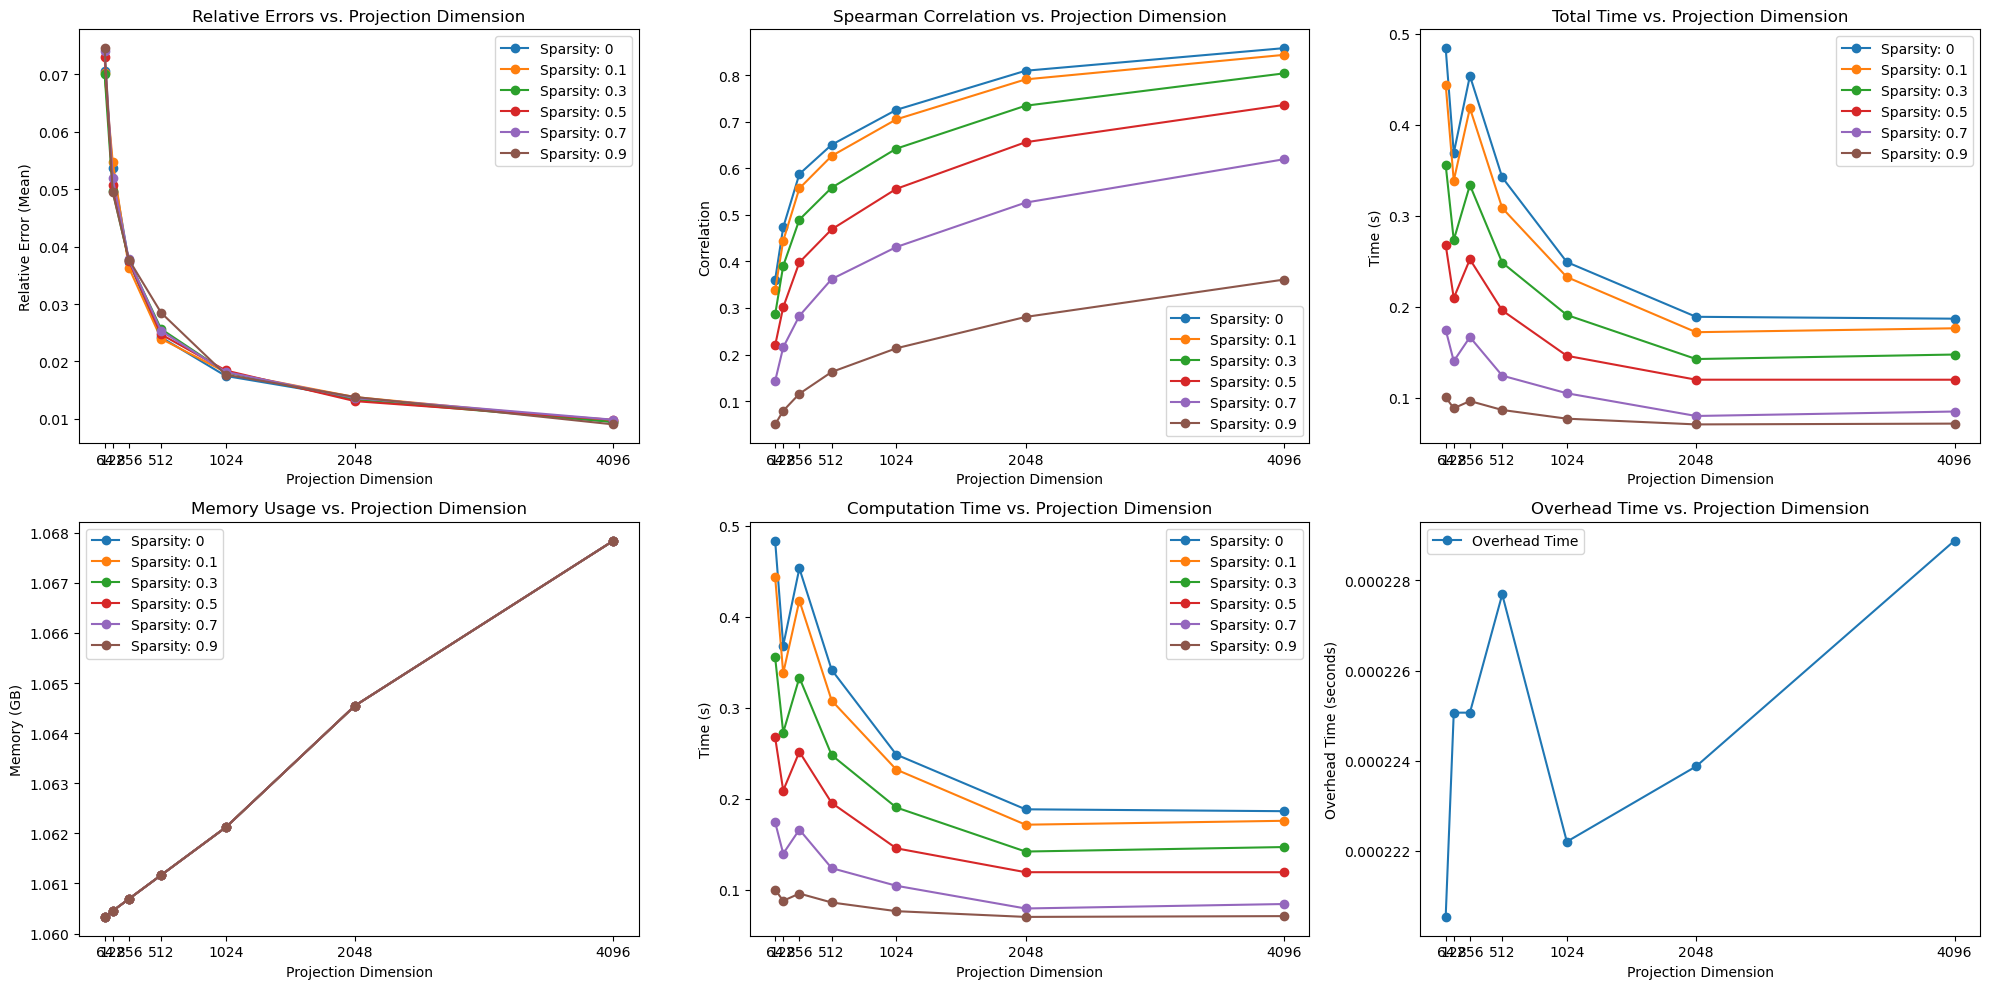

Mode: SJLT_batch


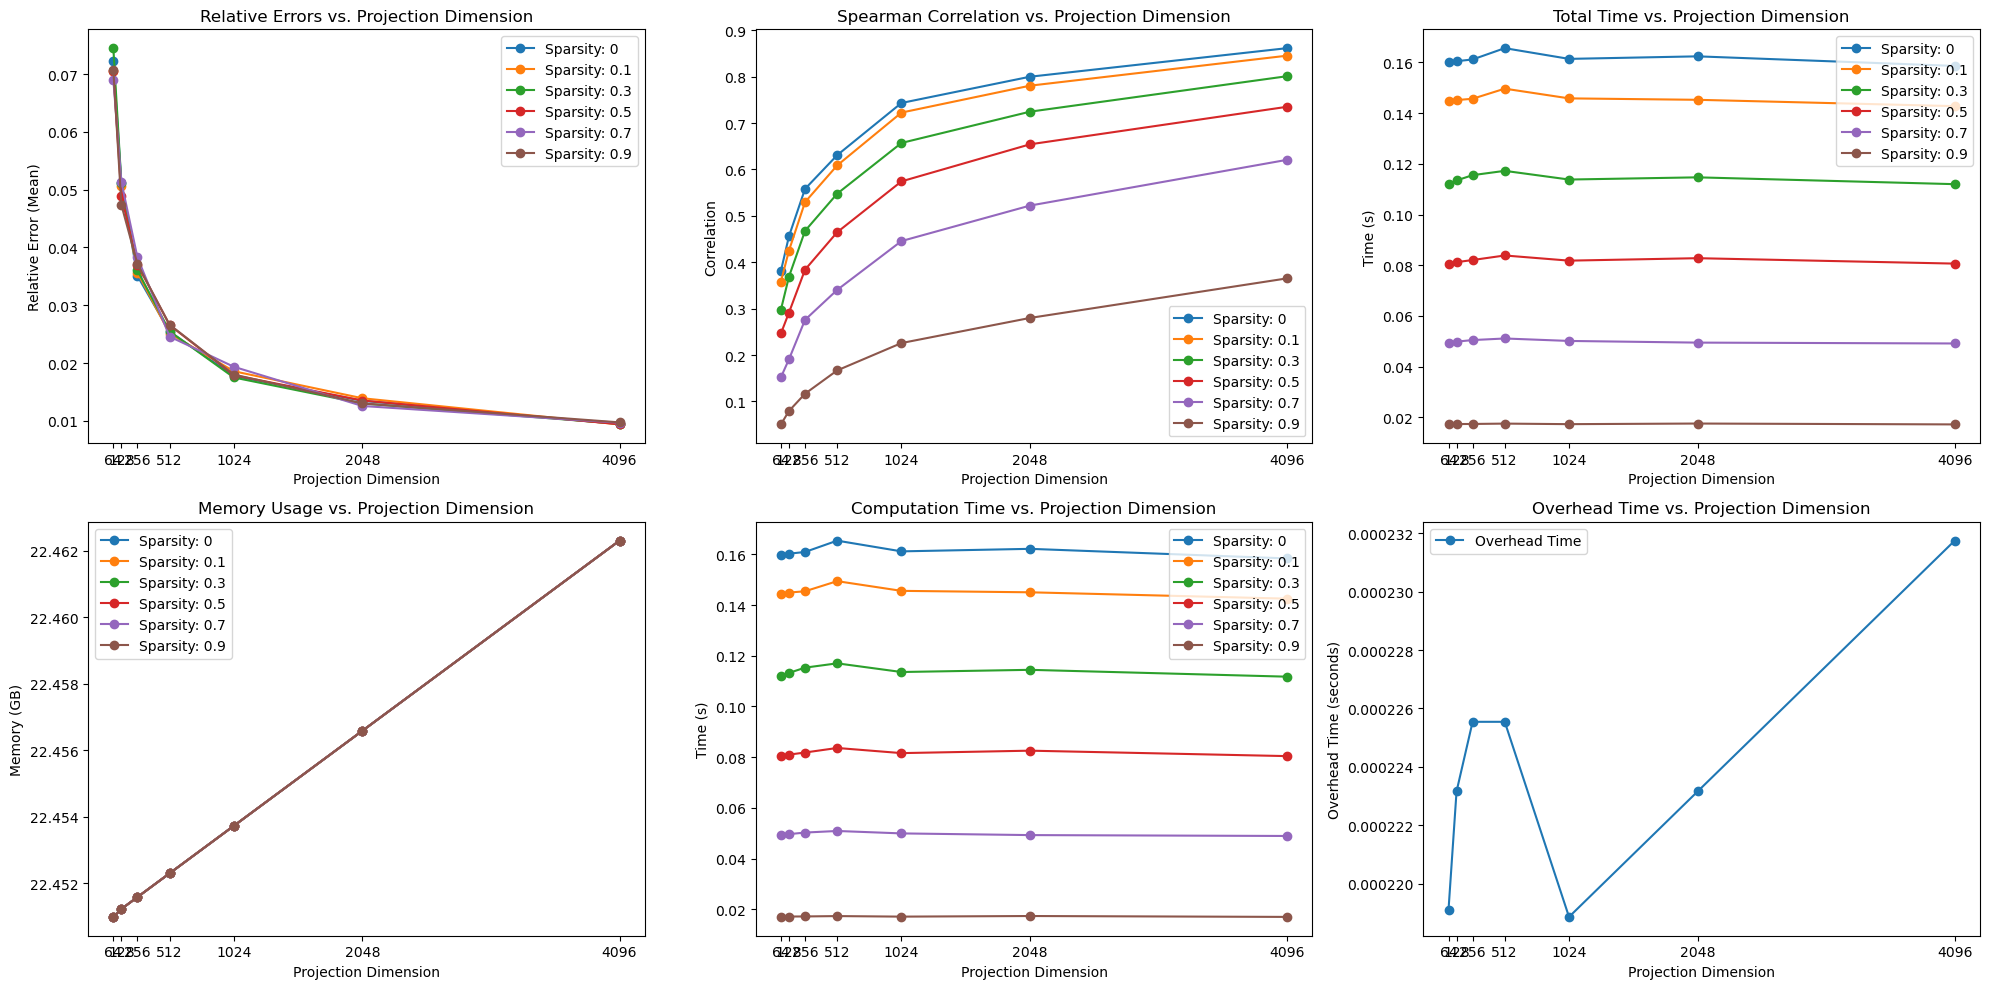

Mode: SJLT_reverse


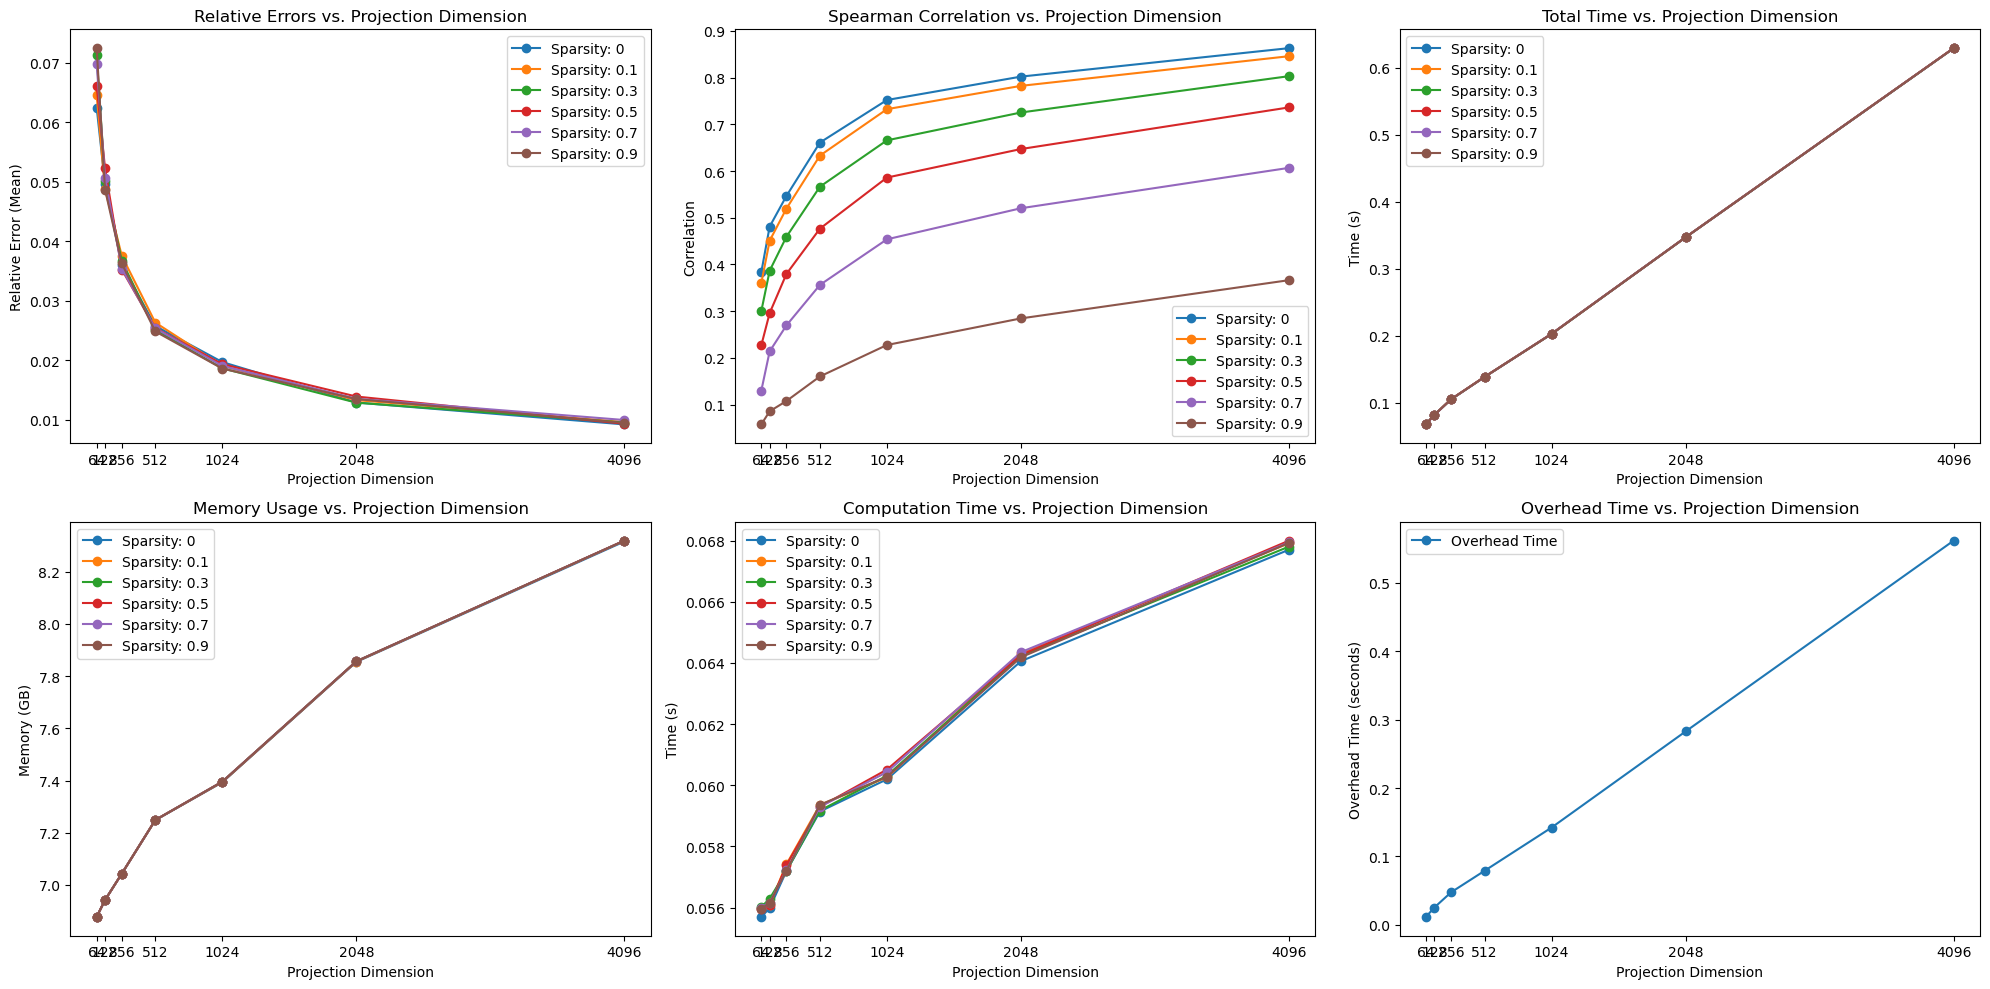

Activation function: sigmoid
Mode: SJLT


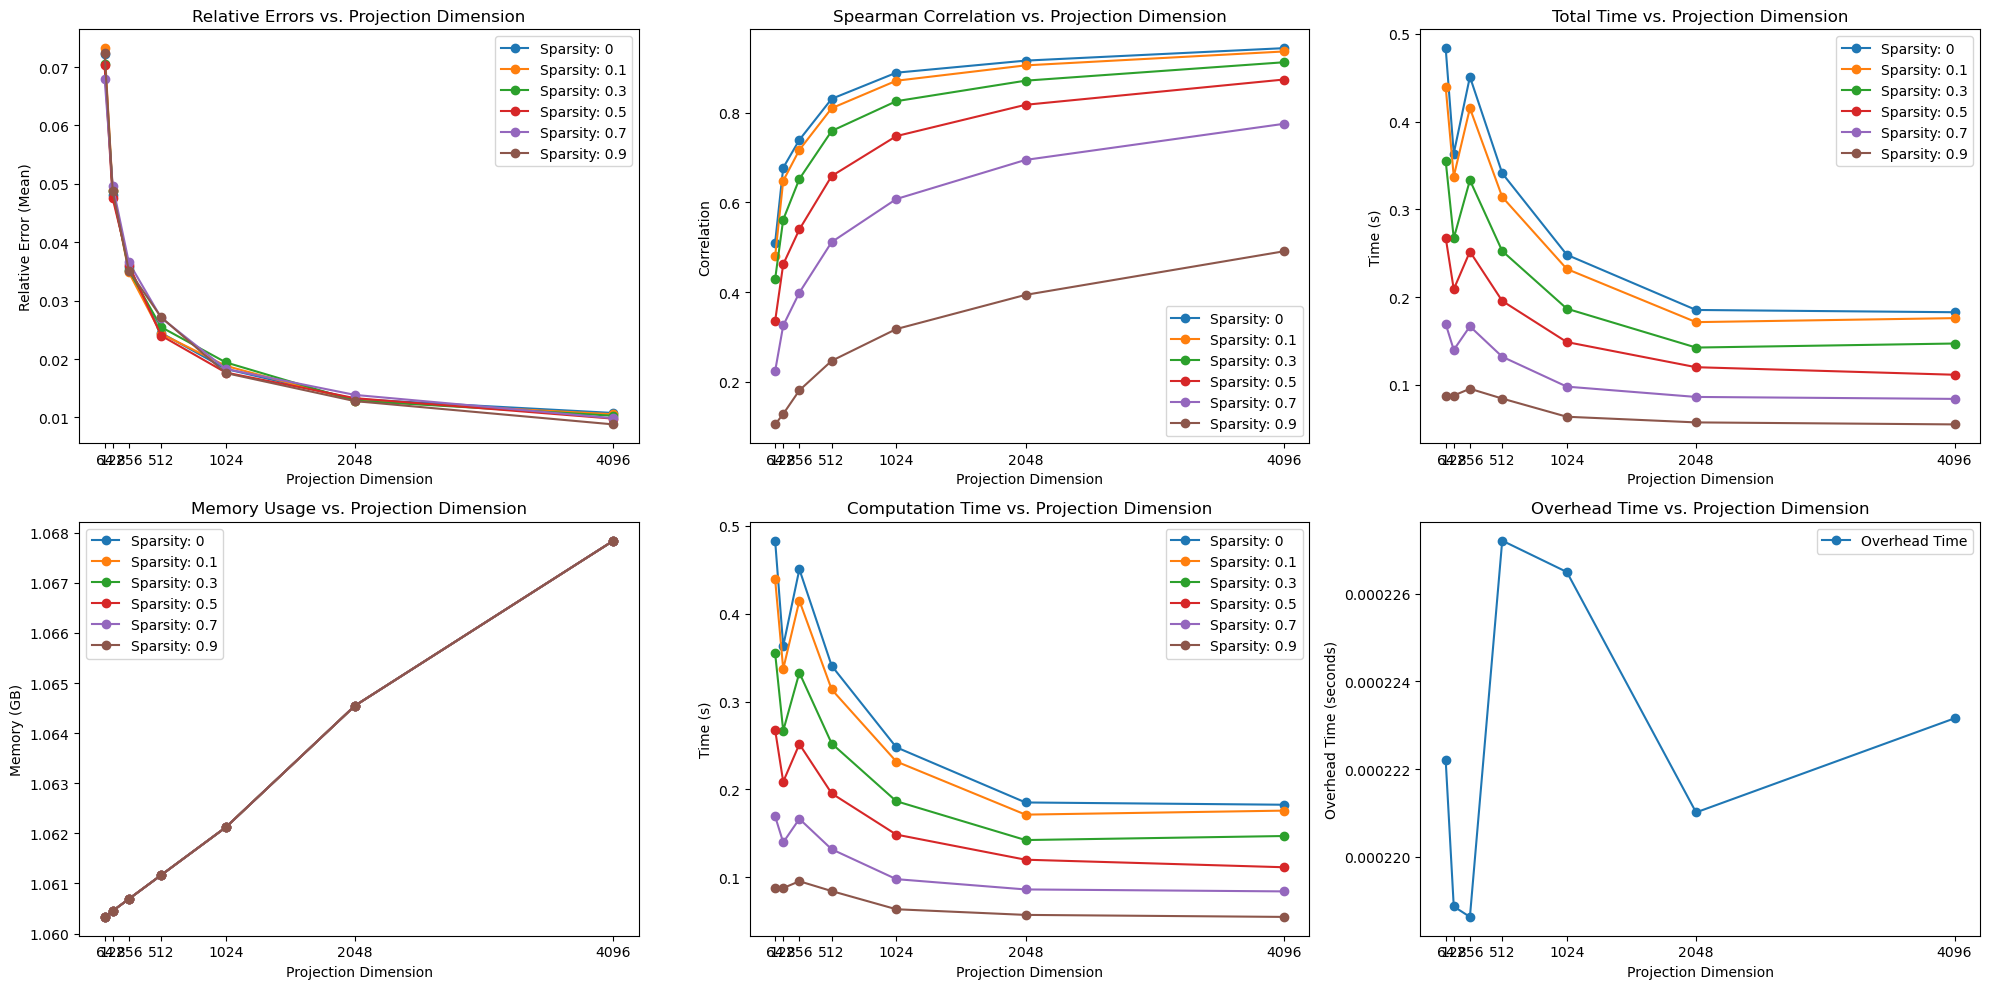

Mode: SJLT_batch


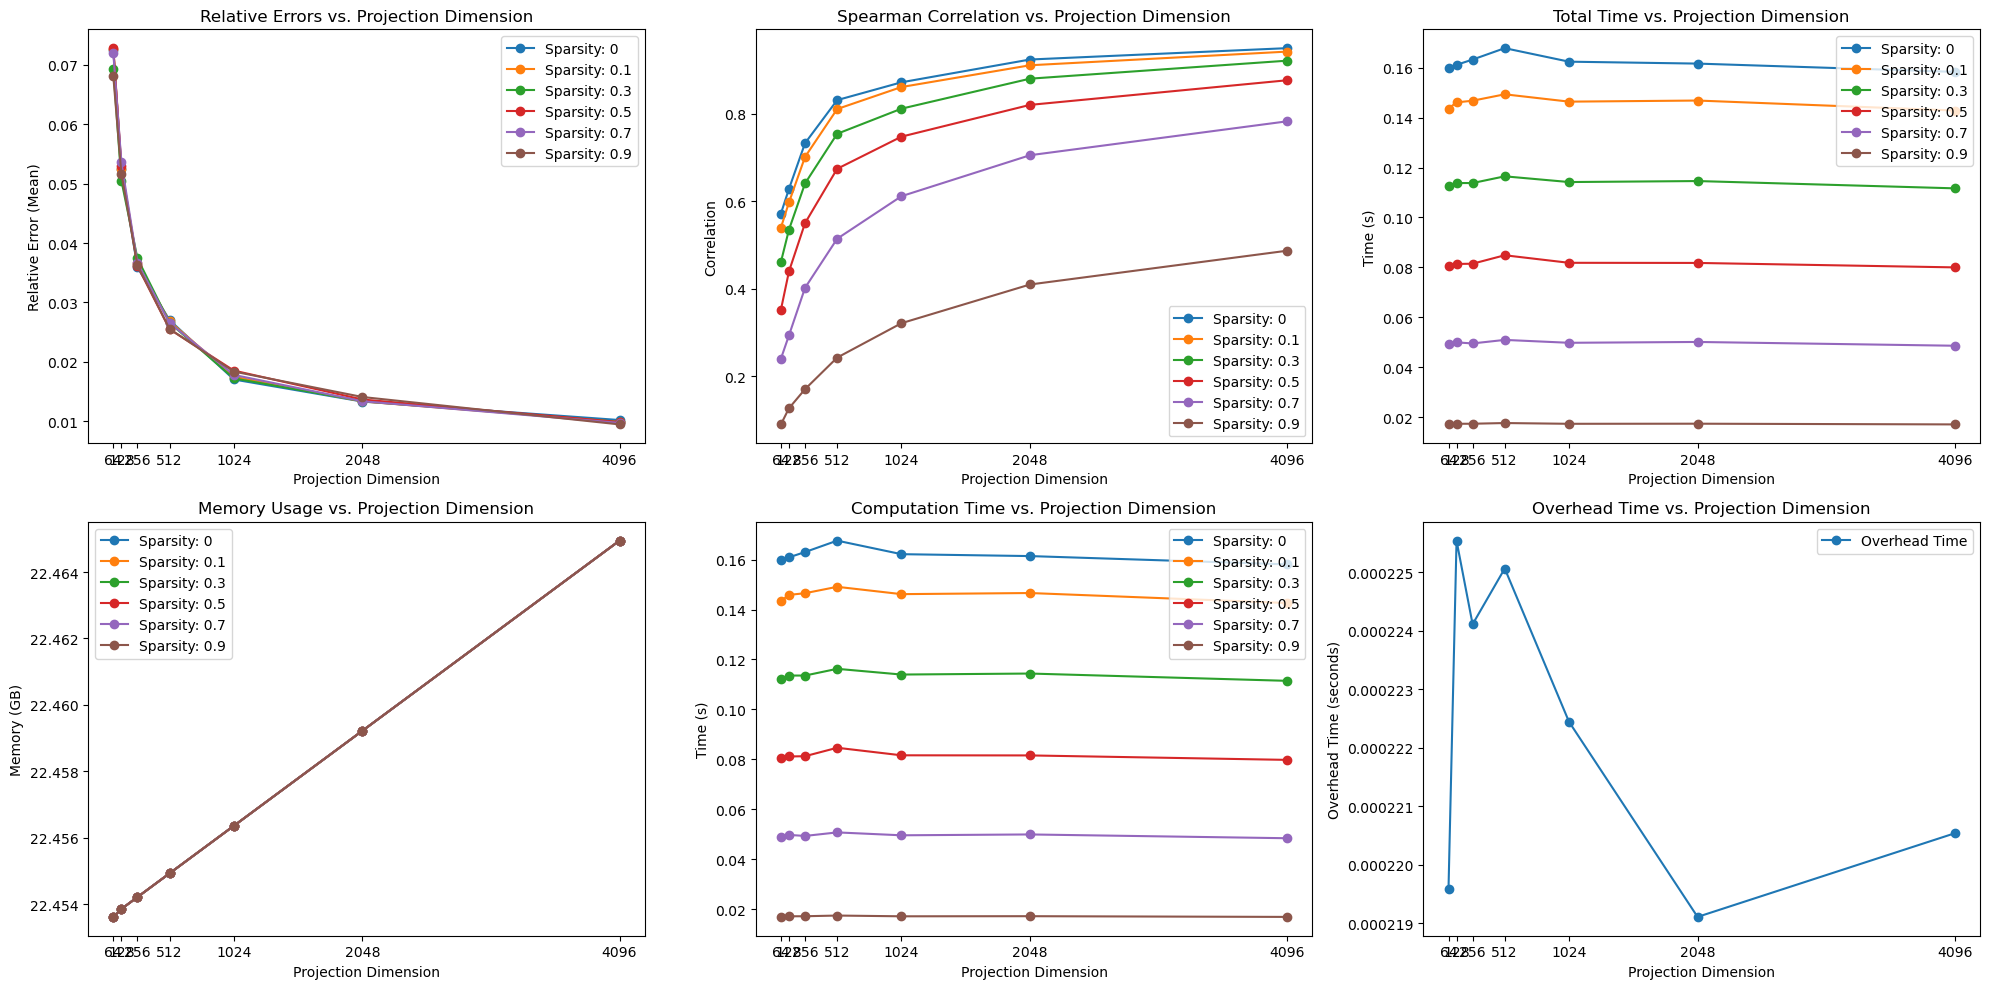

Mode: SJLT_reverse


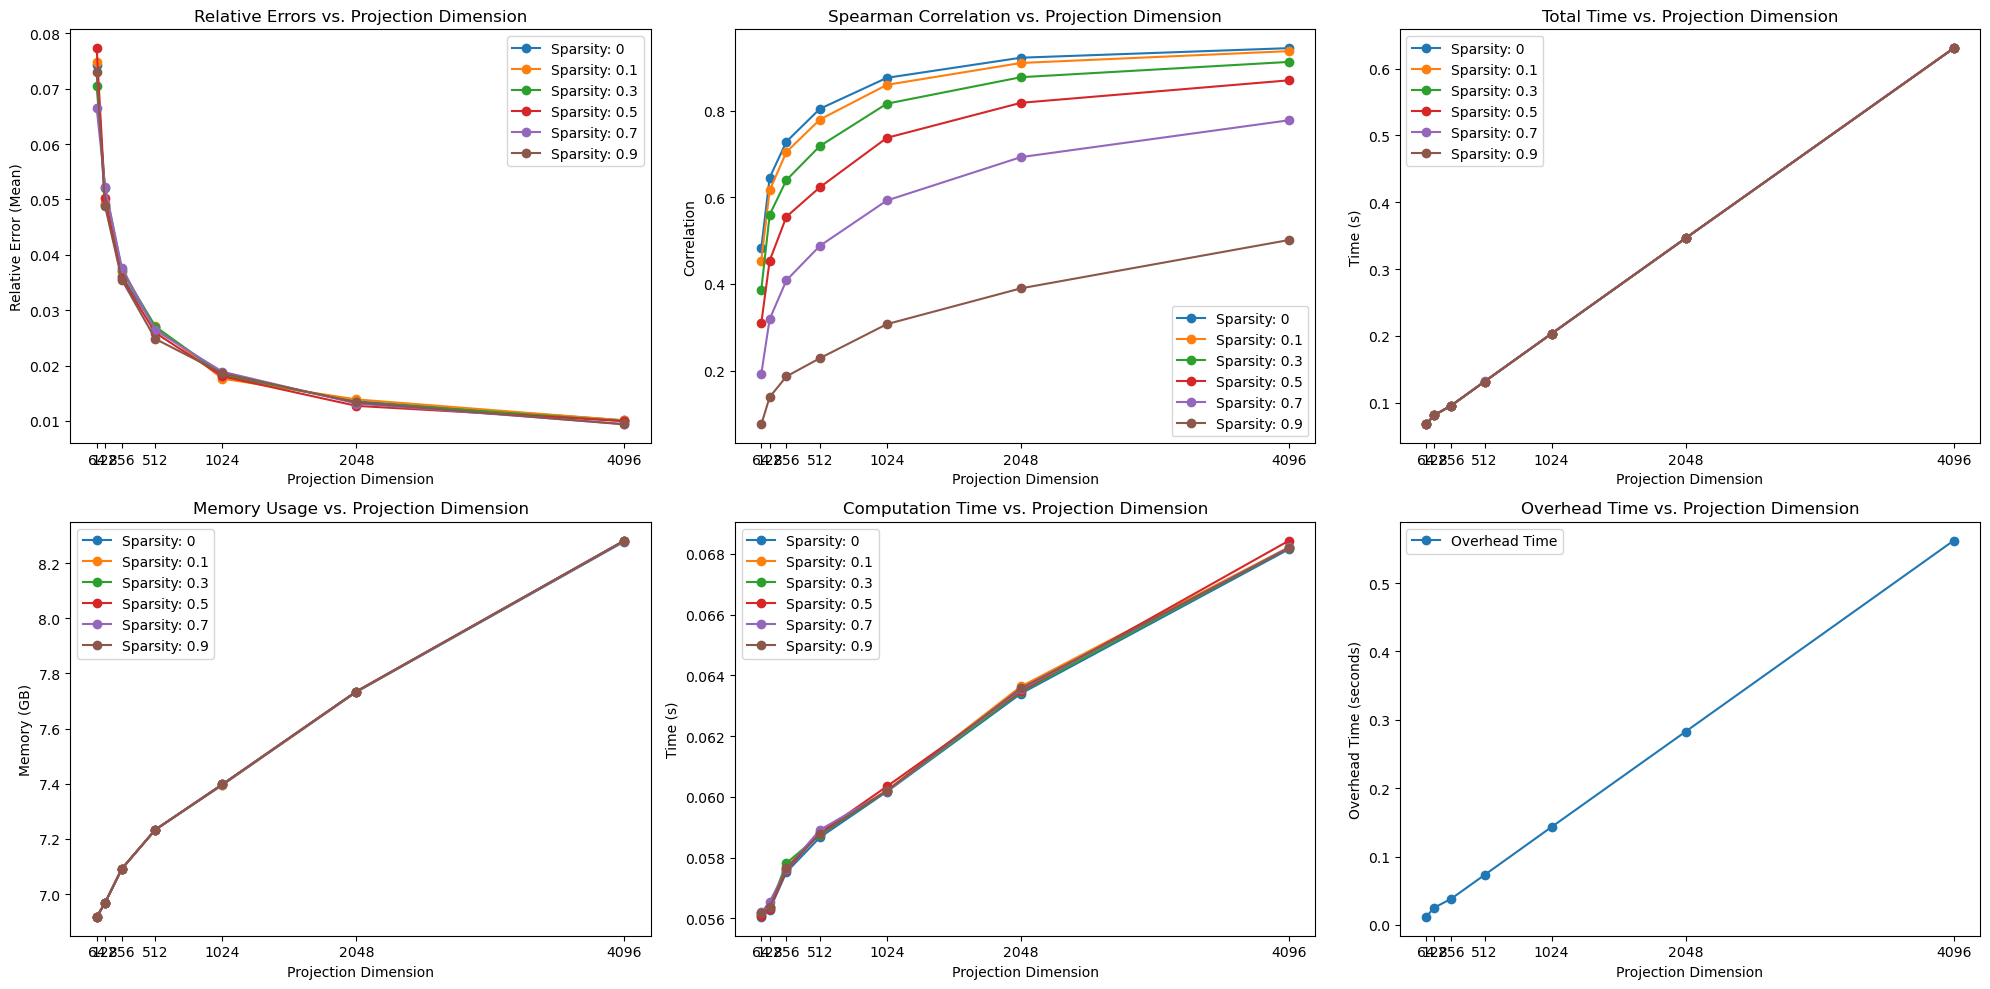

Activation function: leaky_relu
Mode: SJLT


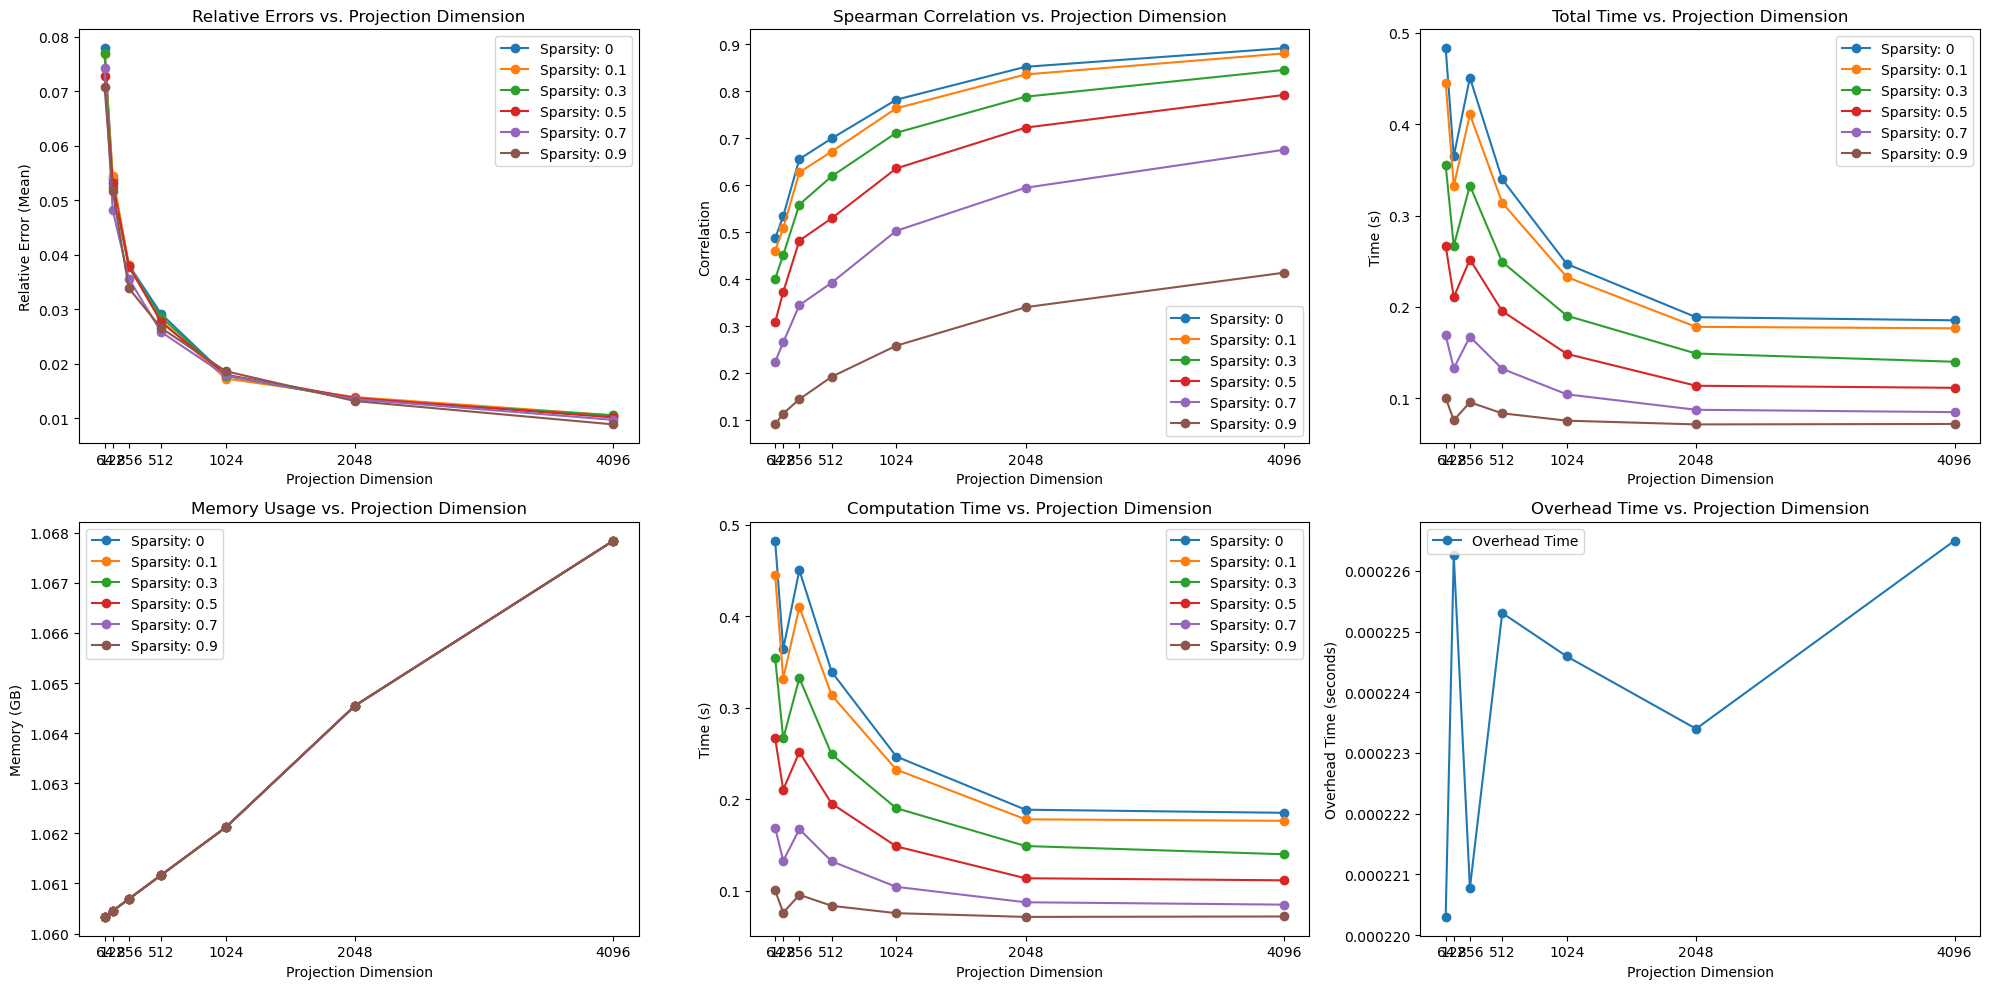

Mode: SJLT_batch


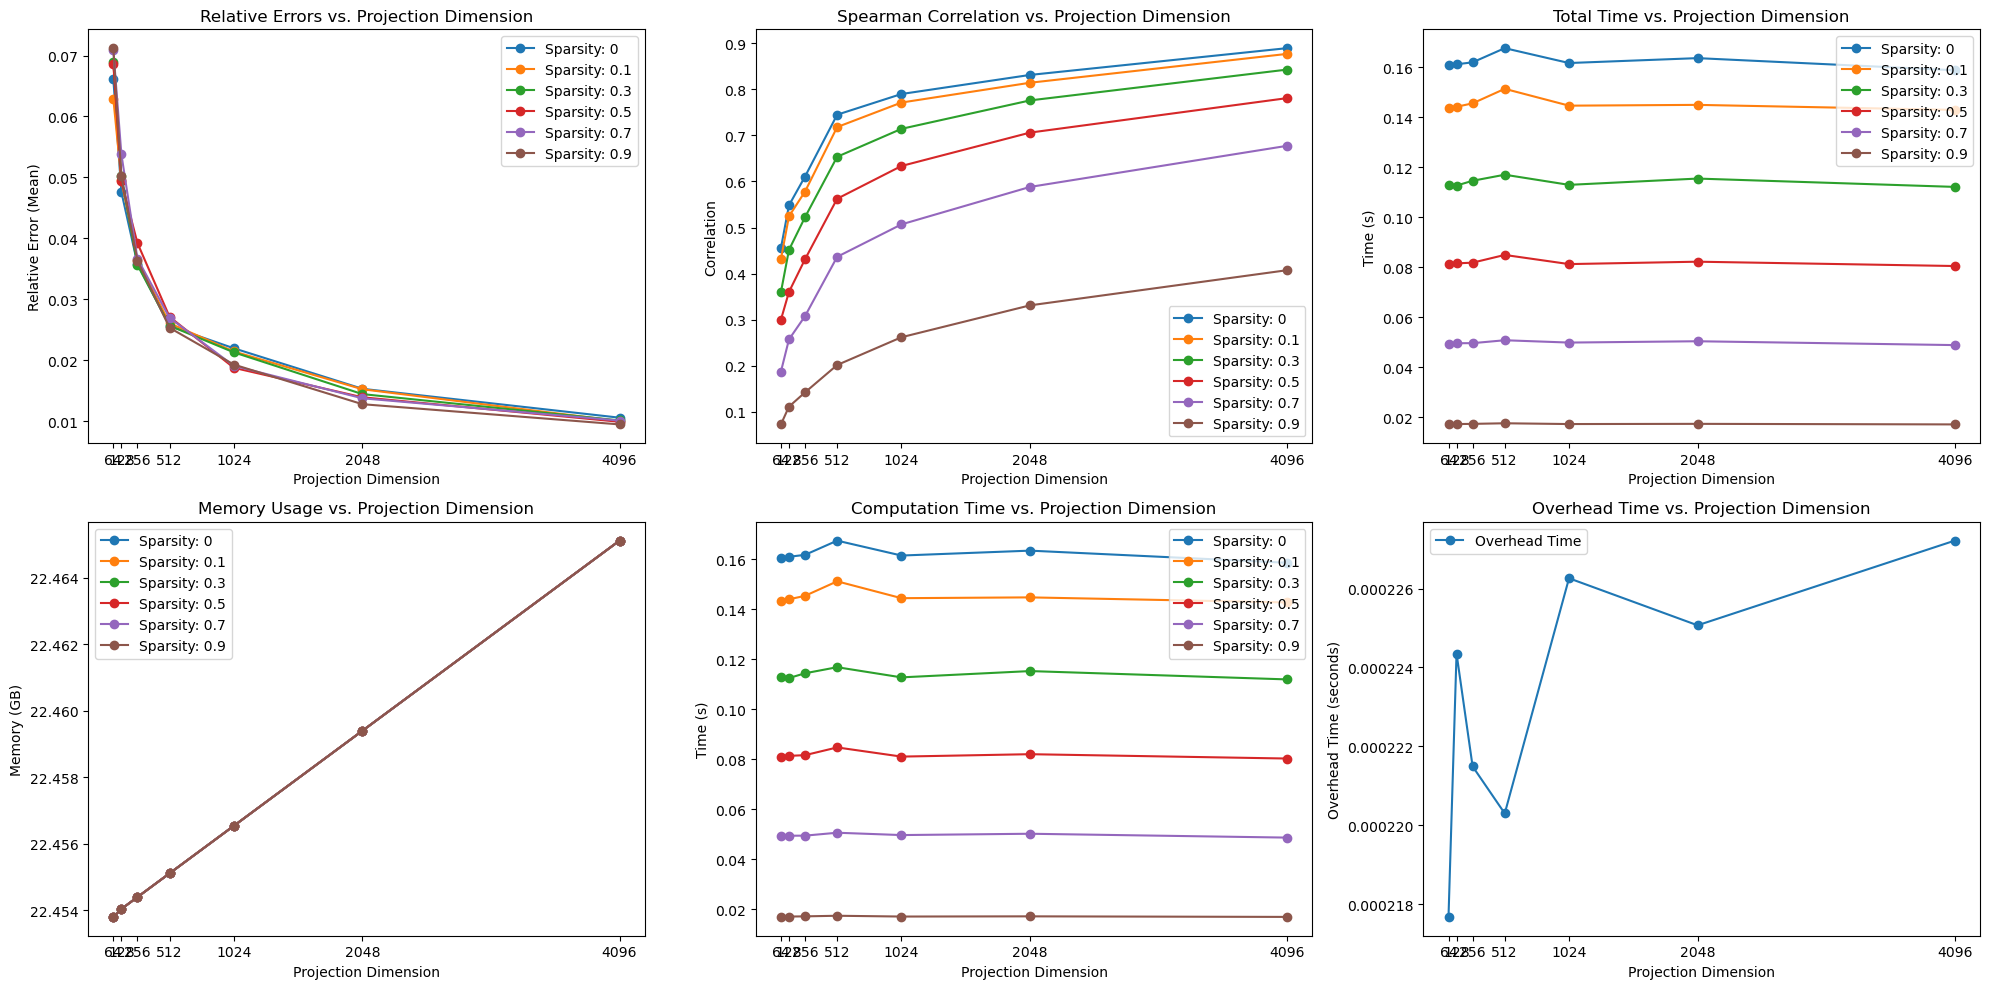

Mode: SJLT_reverse


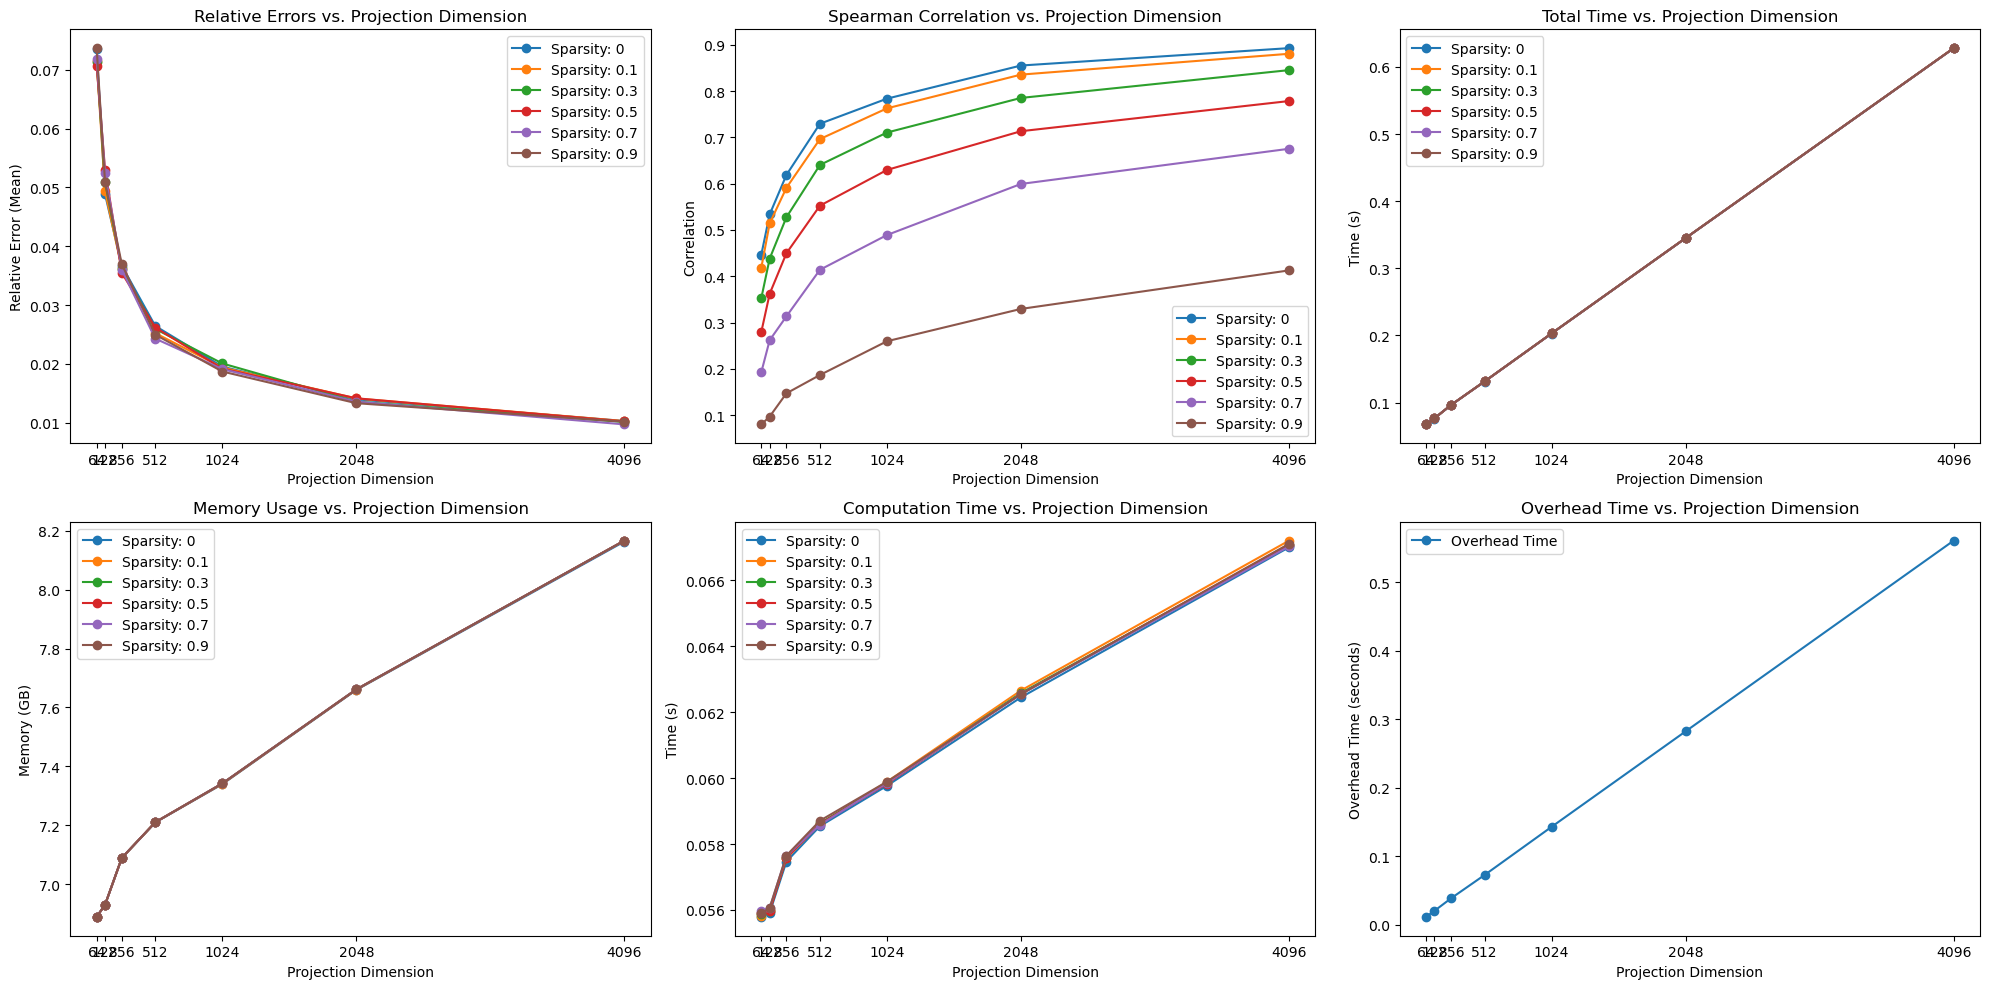

Activation function: linear
Mode: SJLT


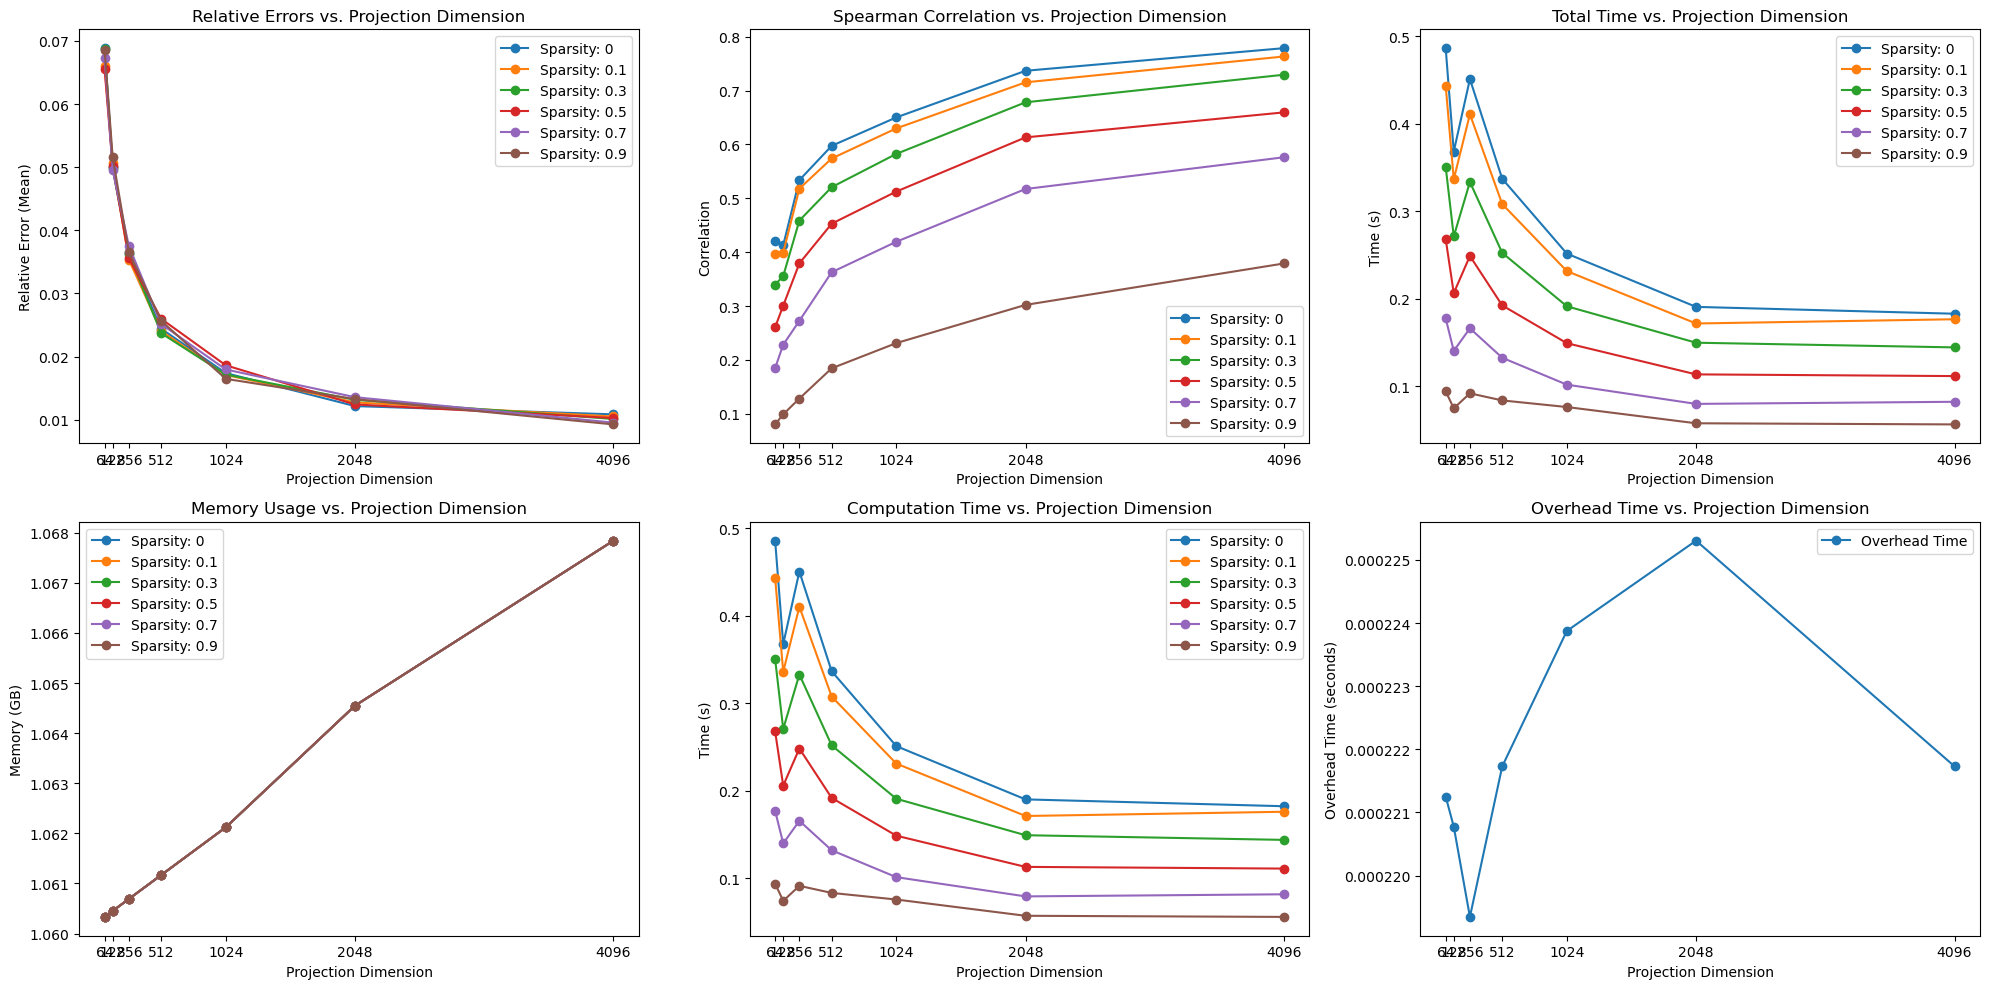

Mode: SJLT_batch


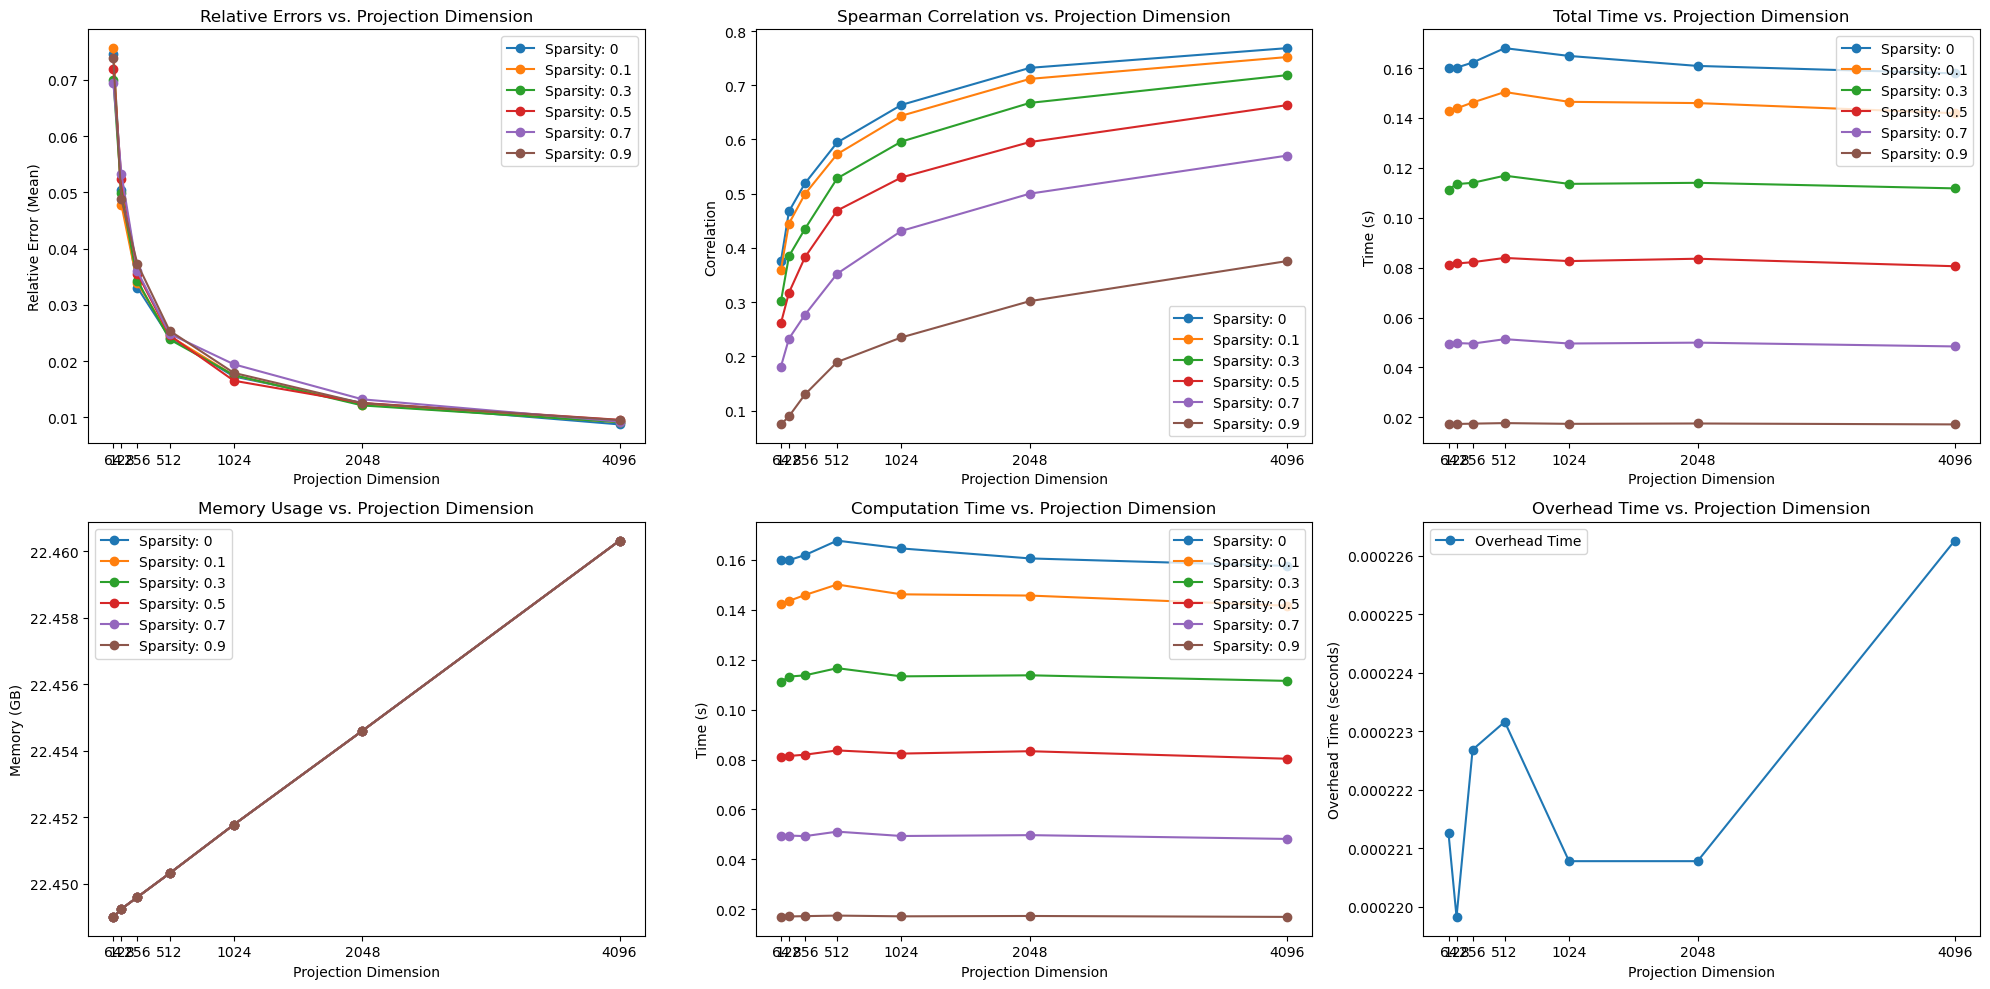

Mode: SJLT_reverse


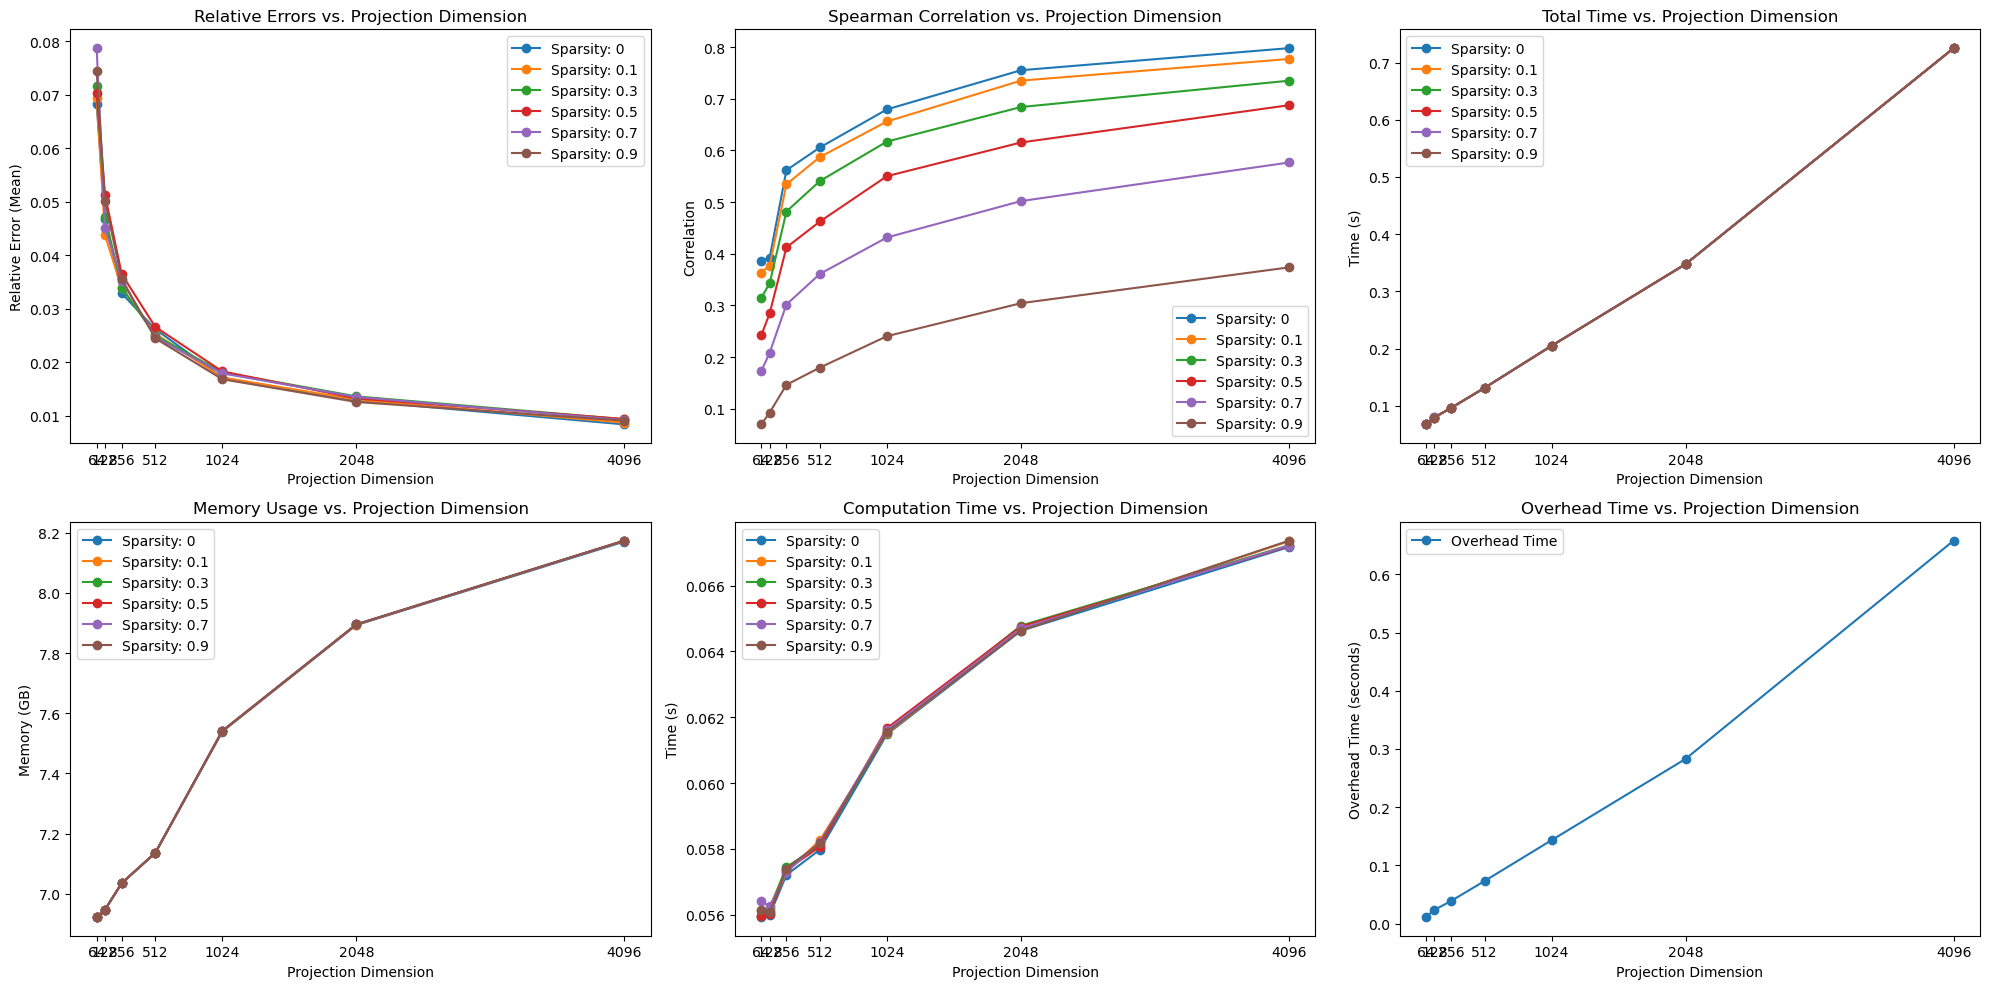

In [5]:
# projection_dims = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
projection_dims = [64, 128, 256, 512, 1024, 2048, 4096]
# sparsity_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
sparsity_levels = [0, 0.1, 0.3, 0.5, 0.7, 0.9]

for activation_fn in ["relu", "tanh", "sigmoid", "leaky_relu", "linear"]:
    print(f"Activation function: {activation_fn}")
    for mode in ["SJLT", "SJLT_batch", "SJLT_reverse"]:
        print(f"Mode: {mode}")
        test_SJLT_sparsity(projection_dims, sparsity_levels=sparsity_levels, mode=mode, activation_fn=activation_fn, c=20, blow_up=1)